In [1]:
import numpy as np
from numpy.linalg import solve
from scipy.linalg import eig
from dataclasses import dataclass
from typing import Optional, Callable, Tuple
import matplotlib.pyplot as plt
from scipy.special import j1
from types import SimpleNamespace
import warnings
import os
import time
# Trapezoid shim (NumPy renamed trapz->trapezoid)
try:
    from numpy import trapezoid as trapz
except Exception:
    try:
        from scipy.integrate import trapezoid as trapz
    except Exception:
        from numpy import trapz
Complex = np.complex128
from numba import njit, prange
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import math
from typing import List

In [2]:
np.set_printoptions(
    precision=3,
    suppress=False,
)

In [3]:


# ---------------------------------------------------------------------------
# Voigt 6 ↔ 4th-rank converters
# ---------------------------------------------------------------------------

# Standard 6-index Voigt mapping:
# 0↔(0,0), 1↔(1,1), 2↔(2,2), 3↔(1,2), 4↔(0,2), 5↔(0,1)

_VOIGT_PAIRS = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1)]
_ALPHA = np.array([1,1,1,1,1,1], float)
_VOIGT_6_LOOKUP = {}
for a, (i, j) in enumerate(_VOIGT_PAIRS):
    _VOIGT_6_LOOKUP[(i, j)] = a
    _VOIGT_6_LOOKUP[(j, i)] = a  # minor symmetry


def voigt6_to_cijkl(C6: np.ndarray) -> np.ndarray:
    """Symmetric map 6×6 Voigt → C_{ijkl}."""
    C = np.zeros((3,3,3,3), dtype=float)
    for I,(i,j) in enumerate(_VOIGT_PAIRS):
        for J,(k,l) in enumerate(_VOIGT_PAIRS):
            C[i,j,k,l] = C6[I,J]
            C[j,i,k,l] = C6[I,J]
            C[i,j,l,k] = C6[I,J]
            C[j,i,l,k] = C6[I,J]
    return C


def cijkl_to_voigt6(C4: np.ndarray) -> np.ndarray:
    """
    Convert 4th-rank c_{ijkl} to 6×6 Voigt stiffness.
    """
    C4 = np.asarray(C4)
    C6 = np.zeros((6, 6), dtype=C4.dtype)
    for i in range(3):
        for j in range(3):
            a = _VOIGT_6_LOOKUP[(i, j)]
            for k in range(3):
                for l in range(3):
                    b = _VOIGT_6_LOOKUP[(k, l)]
                    C6[a, b] = C4[i, j, k, l]
    return C6


In [4]:


def e6_voigt_to_eijk(e6: np.ndarray) -> np.ndarray:
    """
    Convert 3x6 Voigt-form piezo tensor e6[k, J]
    (rows: D1,D2,D3; cols: S1..S6 = 11,22,33,23,13,12)
    into a symmetric 3x3x3 tensor e_ijk[i,j,l].

    Mapping:
      J=0 → (i,j)=(0,0)
      J=1 → (1,1)
      J=2 → (2,2)
      J=3 → (1,2) and (2,1)
      J=4 → (0,2) and (2,0)
      J=5 → (0,1) and (1,0)

    We use the *row* index of e6 as the third index l in e_ijk[i,j,l],
    so that e_ijk[2,2,l] = e6[l, J(33)], which gives e_vec[l] = e_{33,l}
    exactly as your build_piezo_projections expects.
    """
    if e6.shape != (3, 6):
        raise ValueError(f"e6 must be 3x6, got {e6.shape}")

    e_ijk = np.zeros((3, 3, 3), dtype=e6.dtype)

    voigt_pairs = [
        (0, 0),  # J=0 -> 11
        (1, 1),  # J=1 -> 22
        (2, 2),  # J=2 -> 33
        (1, 2),  # J=3 -> 23
        (0, 2),  # J=4 -> 13
        (0, 1),  # J=5 -> 12
    ]

    for l in range(3):           # row of e6
        for J, (i, j) in enumerate(voigt_pairs):
            v = e6[l, J]
            if v == 0.0:
                continue
            e_ijk[i, j, l] += v
            if i != j:
                e_ijk[j, i, l] += v  # enforce symmetry in (i,j)

    return e_ijk


In [5]:
# ---------------------------------------------------------------------------
# Mechanical effective stiffness: C_eff(ω)
# ---------------------------------------------------------------------------

def effective_C(slab, omega: float) -> np.ndarray:
    """
    Complex stiffness for e^{-i ω t} convention.

    Kelvin–Voigt:  σ = C:ε  - i ω η:ε   ⇒   C_eff = C - i ω η
    Optional loss-tangent:  C_eff ≈ C * (1 - i tanδ)   (small tanδ)

    Priority:
      1) If slab.eta is provided (4th-rank or 6×6 Voigt), use C - i ω η.
      2) Else if slab.tan_delta is provided (scalar or tensor-like), use C*(1 - i tanδ).
      3) Else return C.
    """
    C = np.asarray(slab.C)
    eta = getattr(slab, "eta", None)
    tan_delta = getattr(slab, "tan_delta", None)

    if eta is not None:
        eta = np.asarray(eta)
        return C - 1j * omega * eta

    if tan_delta is not None:
        td = np.asarray(tan_delta)
        return C * (1.0 - 1j * td)

    return C
  # assuming you have this somewhere globally

# --- Voigt → full 4th-rank mapping ---

_voigt_to_pair = np.array([
    [0, 0],  # 0 -> 11
    [1, 1],  # 1 -> 22
    [2, 2],  # 2 -> 33
    [1, 2],  # 3 -> 23
    [0, 2],  # 4 -> 13
    [0, 1],  # 5 -> 12
], dtype=np.int64)


def voigt6_to_C4(C6: np.ndarray) -> np.ndarray:
    """
    Convert a 6×6 Voigt stiffness matrix C6 into a 3×3×3×3 stiffness tensor C4.
    """
    C6 = np.asarray(C6, dtype=Complex)
    C4 = np.zeros((3, 3, 3, 3), dtype=Complex)

    for I in range(6):
        i, j = _voigt_to_pair[I]
        for J in range(6):
            k, l = _voigt_to_pair[J]
            C4[i, j, k, l] = C6[I, J]

    return C4


def effective_C_general(
    C: np.ndarray,
    omega: float | None = None,
    eta: np.ndarray | None = None,
    tan_delta: float | np.ndarray | None = None,
) -> np.ndarray:
    """
    Return complex stiffness C_eff for e^{-i ω t} convention.

      σ = C:ε  - i ω η:ε   ⇒   C_eff = C - i ω η      (Kelvin–Voigt)
      C_eff ≈ C (1 - i tanδ)                          (loss tangent model)

    Priority:
      1) If `eta` is provided (same shape as C) and `omega` is not None:
         use C_eff = C - i ω η.
      2) Else if `tan_delta` is provided: C_eff = C * (1 - i tanδ).
      3) Else: C_eff = C (real).

    EXTRA BEHAVIOUR:
      • If the *input* C is 6×6 (Voigt stiffness), we treat it as Voigt
        and return a 3×3×3×3 stiffness tensor after adding loss.
      • If the input is already 3×3×3×3, it stays 4th-rank.
      • Otherwise (e.g. 3×3 dielectric), shape is left as-is.
    """
    C = np.asarray(C, dtype=Complex)

    # Kelvin–Voigt if full viscosity η is supplied
    if eta is not None:
        if omega is None:
            raise ValueError("omega must be provided when using eta in effective_C_general.")
        eta = np.asarray(eta, dtype=Complex)
        C_eff = C - 1j * omega * eta
    # Simple loss-tangent model
    elif tan_delta is not None:
        td = np.asarray(tan_delta, dtype=Complex)
        C_eff = C * (1.0 - 1j * td)
    else:
        C_eff = C

    # --- Auto-convert 6×6 Voigt stiffness to 3×3×3×3 ---
    if C_eff.ndim == 2 and C_eff.shape == (6, 6):
        return voigt6_to_C4(C_eff)

    # For 3×3×3×3 or anything else, just return as-is
    return C_eff

def effective_eps(
    eps: np.ndarray,
    omega: float,
    tan_delta_eps: float | np.ndarray | None = None,
    sigma: float | np.ndarray | None = None,
) -> np.ndarray:
    """
    Complex dielectric tensor for e^{-i ω t} convention.

    Maxwell with conduction:
        ∇×H = J + ∂D/∂t,   J = σ E,   D = ε E
      with fields ~ e^{-i ω t} ⇒ ∂D/∂t = -i ω D

    We define ε_eff via:
        -i ω ε_eff E = σ E - i ω ε E
        ⇒ ε_eff = ε - i σ / ω

    For a dielectric loss tangent tanδ_ε (small):
        ε_eff ≈ ε * (1 - i tanδ_ε)

    Priority (mirrors effective_C):
      1) If σ is provided (scalar or tensor-like), use ε_eff = ε - i σ/ω.
      2) Then, if tan_delta_eps is provided, multiply by (1 - i tanδ_ε).
      3) Else return ε as-is.

    Parameters
    ----------
    eps : array_like
        Base permittivity (scalar or 3×3 tensor), typically ε_0 ε_r.
    omega : float
        Angular frequency [rad/s].
    tan_delta_eps : float or array_like, optional
        Dielectric loss tangent tanδ_ε (scalar or same shape as eps).
    sigma : float or array_like, optional
        Conductivity σ [S/m] (scalar or same shape as eps).

    Returns
    -------
    eps_eff : ndarray (complex)
        Complex effective permittivity tensor with the same shape as eps.
    """
    eps_arr = np.array(eps, dtype=Complex)
    eps_eff = eps_arr.copy()

    # 1) Conduction loss: ε_eff = ε - i σ / ω
    if sigma is not None:
        sigma_arr = np.array(sigma, dtype=float)
        eps_eff = eps_eff + 1j * sigma_arr / omega

    # 2) Dielectric loss tangent: ε_eff *= (1 - i tanδ_ε)
    if tan_delta_eps is not None:
        td_arr = np.array(tan_delta_eps, dtype=float)
        eps_eff = eps_eff * (1.0 +1j * td_arr)

    return eps_eff



In [6]:


@njit
def compute_s_and_khat(sx: float, sy: float, tol_s: float):
    """
    Shared helper: get s_|| and khat for both elastic and piezo generators.

    Returns:
        s   : float, in-plane slowness magnitude (>= tol_s)
        khat: (2,) float64 array, unit in-plane direction
    """
    s_par = np.hypot(sx, sy)

    khat = np.empty(2, dtype=np.float64)

    if s_par <= tol_s:
        # Arbitrary in-plane direction at normal incidence
        khat[0] = 1.0
        khat[1] = 0.0
        s = tol_s
    else:
        inv_s_par = 1.0 / s_par
        khat[0] = sx * inv_s_par
        khat[1] = sy * inv_s_par
        s = s_par

    return s, khat



In [7]:
from types import SimpleNamespace

def build_layer_with_effective_C(LN_layer: dict, omega: float) -> dict:
    C6 = LN_layer["C6"]
    C4 = voigt6_to_cijkl(C6)

    slab = SimpleNamespace(C=C4)
    if "eta6" in LN_layer and LN_layer["eta6"] is not None:
        slab.eta = voigt6_to_cijkl(LN_layer["eta6"])
    if "tan_delta" in LN_layer and LN_layer["tan_delta"] is not None:
        slab.tan_delta = LN_layer["tan_delta"]

    C4_eff = effective_C(slab, omega)
    out = dict(LN_layer)
    out["C4"]   = C4
    out["Ceff"] = C4_eff
    return out


In [8]:
def mech_bc_to_flag(mech_bc_top: str) -> int:
    mbc = mech_bc_top.lower()
    if mbc == "free":
        return 0
    elif mbc == "clamped":
        return 1
    elif mbc in ("none", "transparent", "matched"):
        return 2
    else:
        raise ValueError(f"Unknown mech_bc_top={mech_bc_top!r}")


In [9]:
from numba import njit
import numpy as np

Complex = Complex

@njit
def build_mech_QRT_numba(C4_eff, khat):
    """
    Numba-safe mechanical projections:

      Q_il = c_{i3l3}
      R_il = c_{i3lα} k̂_α
      T_il = c_{iα lβ} k̂_α k̂_β

    Assumes:
      C4_eff.shape == (3,3,3,3)
      khat.shape   == (2,)
    """
    iz = 2

    Q = np.zeros((3, 3), dtype=Complex)
    R = np.zeros((3, 3), dtype=Complex)
    T = np.zeros((3, 3), dtype=Complex)

    for i in range(3):
        for l in range(3):
            # Q_il = c_{i3l3}
            Q[i, l] = C4_eff[i, iz, l, iz]

            tmpR = 0.0 + 0.0j
            tmpT = 0.0 + 0.0j

            # alpha, beta ∈ {0,1}
            for a in range(2):
                tmpR += C4_eff[i, iz, l, a] * khat[a]
                for b in range(2):
                    tmpT += C4_eff[i, a, l, b] * khat[a] * khat[b]

            R[i, l] = tmpR
            T[i, l] = tmpT

    return Q, R, T


In [10]:
@njit
def build_piezo_projections_numba(e_ijk, eps_kl, khat):
    """
    Numba-safe version of build_piezo_projections.

    e_ijk: (3,3,3)
    eps_kl: (3,3)
    khat: (2,) in-plane unit vector
    """
    iz = 2
    # in-plane indices {0,1}
    alpha_idx0 = 0
    alpha_idx1 = 1

    e_vec = np.zeros(3, dtype=Complex)
    B_vec = np.zeros(3, dtype=Complex)
    W_vec = np.zeros(3, dtype=Complex)
    A_vec = np.zeros(3, dtype=Complex)

    # dielectric projections
    eps_s   = eps_kl[iz, iz]
    gamma_s = 0.0 + 0.0j
    alpha_s = 0.0 + 0.0j

    # gamma_s = eps_{3a} k_a, a∈{0,1}
    gamma_s += eps_kl[iz, alpha_idx0] * khat[alpha_idx0]
    gamma_s += eps_kl[iz, alpha_idx1] * khat[alpha_idx1]

    # alpha_s = eps_{ab} k_a k_b
    alpha_s += eps_kl[alpha_idx0, alpha_idx0] * khat[alpha_idx0] * khat[alpha_idx0]
    alpha_s += eps_kl[alpha_idx0, alpha_idx1] * khat[alpha_idx0] * khat[alpha_idx1]
    alpha_s += eps_kl[alpha_idx1, alpha_idx0] * khat[alpha_idx1] * khat[alpha_idx0]
    alpha_s += eps_kl[alpha_idx1, alpha_idx1] * khat[alpha_idx1] * khat[alpha_idx1]

    for l in range(3):
        # e_l = e_{33l}
        e_vec[l] = e_ijk[iz, iz, l]

        # B,W,A projections
        tmpB = 0.0 + 0.0j
        tmpW = 0.0 + 0.0j
        tmpA = 0.0 + 0.0j

        # a=0
        a = alpha_idx0
        tmpB += e_ijk[iz, a, l] * khat[a]
        tmpW += e_ijk[a, iz, l] * khat[a]

        # contributions to A from (a=0,b=0,1)
        tmpA += e_ijk[a, alpha_idx0, l] * khat[a] * khat[alpha_idx0]
        tmpA += e_ijk[a, alpha_idx1, l] * khat[a] * khat[alpha_idx1]

        # a=1
        a = alpha_idx1
        tmpB += e_ijk[iz, a, l] * khat[a]
        tmpW += e_ijk[a, iz, l] * khat[a]

        # contributions to A from (a=1,b=0,1)
        tmpA += e_ijk[a, alpha_idx0, l] * khat[a] * khat[alpha_idx0]
        tmpA += e_ijk[a, alpha_idx1, l] * khat[a] * khat[alpha_idx1]

        B_vec[l] = tmpB
        W_vec[l] = tmpW
        A_vec[l] = tmpA

    return e_vec, B_vec, W_vec, A_vec, eps_s, gamma_s, alpha_s


In [11]:
@njit
def build_tilded_blocks_numba(Q, R, T,
                              e_vec, B_vec, W_vec, A_vec,
                              eps_s, gamma_s, alpha_s):
    """
    Numba-safe version of build_tilded_blocks.
    """
    Qtilde = np.zeros((4, 4), dtype=Complex)
    Rtilde = np.zeros((4, 4), dtype=Complex)
    Ttilde = np.zeros((4, 4), dtype=Complex)

    # Q̃
    for i in range(3):
        for j in range(3):
            Qtilde[i, j] = Q[i, j]
        Qtilde[i, 3] = e_vec[i]
        Qtilde[3, i] = e_vec[i]
    Qtilde[3, 3] = -eps_s

    # R̃
    for i in range(3):
        for j in range(3):
            Rtilde[i, j] = R[i, j]
        Rtilde[i, 3] = B_vec[i]
        Rtilde[3, i] = W_vec[i]
    Rtilde[3, 3] = -gamma_s

    # T̃
    for i in range(3):
        for j in range(3):
            Ttilde[i, j] = T[i, j]
        Ttilde[i, 3] = A_vec[i]
        Ttilde[3, i] = A_vec[i]
    Ttilde[3, 3] = -alpha_s

    return Qtilde, Rtilde, Ttilde


In [12]:
@njit
def build_piezo_QRT_tilde_numba(C4_eff, e_ijk, eps_kl, khat):
    """
    Numba version of build_piezo_QRT_tilde.
    """
    # 3×3 mechanical Q, R, T from anisotropic elasticity
    Q, R, T = build_mech_QRT_numba(C4_eff, khat)

    # piezo projections
    (e_vec, B_vec, W_vec, A_vec,
     eps_s, gamma_s, alpha_s) = build_piezo_projections_numba(e_ijk, eps_kl, khat)

    # tilded blocks
    Qtilde, Rtilde, Ttilde = build_tilded_blocks_numba(
        Q, R, T,
        e_vec, B_vec, W_vec, A_vec,
        eps_s, gamma_s, alpha_s
    )

    # return also R̃ᵀ as a separate array
    RTtilde = Rtilde.T.copy()
    return Qtilde, Rtilde, RTtilde, Ttilde


In [13]:
from numba import njit
import numpy as np

@njit
def safe_inv_4x4(Q):
    # crude scale of the matrix
    maxabs = 0.0
    for i in range(4):
        for j in range(4):
            val = abs(Q[i, j])
            if val > maxabs:
                maxabs = val

    if maxabs == 0.0:
        # completely zero → nothing to invert (this shouldn't happen physically)
        raise np.linalg.LinAlgError("Qtil is all zeros")

    # determinant check
    detQ = np.linalg.det(Q)
    # threshold: if det is tiny relative to scale^4, treat as nearly singular
    if abs(detQ) < 1e-14 * (maxabs**4):
        # add a tiny isotropic regularisation
        eps = 1e-8 * maxabs
        Qreg = Q.copy()
        for i in range(4):
            Qreg[i, i] = Qreg[i, i] + eps
        return np.linalg.inv(Qreg)
    else:
        return np.linalg.inv(Q)


In [14]:
@njit
def stroh_generator_elastic_slow_numba(
    C4_eff: np.ndarray,
    rho: float,
    sx: float,
    sy: float,
    tol_s: float = 1e-15,
) -> np.ndarray:
    """
    Numba-safe 6×6 elastic Stroh generator N for the canonical state

        Φ = [ u_x, u_y, u_z,  p_x, p_y, p_z ]ᵀ.

    Slowness form: s_|| = |(sx, sy)|, so N has no explicit ω.
    """
    # 1. Shared slowness + direction
    s, khat = compute_s_and_khat(sx, sy, tol_s)

    # 2. Mechanical Q,R,T (3×3 each)
    # You’ll need a numba-ised version of this:
    #   build_mech_QRT_numba(C4_eff, khat)
    Q, R, T = build_mech_QRT_numba(C4_eff, khat)

    # 3. Inverse and transposes
    Qinv = np.linalg.inv(Q)
    RT = R.T

    # 4. "Mass" term: in slowness form this is just rho * I₃
    rhoM = rho * np.eye(3)

    # 5. Blocks of the 6×6 generator
    #    Φ' = N Φ, with λ = i k_z ⇒ k_z = -i λ
    #
    #    N11 = -i s Q⁻¹ Rᵀ
    #    N12 = -Q⁻¹
    #    N21 = ρ I₃ + s² (R Q⁻¹ Rᵀ - T)
    #    N22 = -i s R Q⁻¹
    #
    N11 = -1j * s * (Qinv @ RT)
    N12 = -Qinv
    N21 = rhoM + (s * s) * (R @ Qinv @ RT - T)
    N22 = -1j * s * (R @ Qinv)

    # 6. Assemble N (must be complex!)
    N = np.zeros((6, 6), dtype=Complex)

    N[0:3, 0:3] = N11
    N[0:3, 3:6] = N12
    N[3:6, 0:3] = N21
    N[3:6, 3:6] = N22

    return N


In [15]:


@njit
def stroh_generator_piezo_slow_numba(C4_eff,
                                     e_ijk,
                                     eps_tensor,
                                     rho,
                                     sx,
                                     sy,
                                     tol_s):
    """
    Numba-safe piezoelectric Stroh generator in slowness form.

    State Φ = [u_x,u_y,u_z, Φ,  p_x,p_y,p_z, q]^T.

    Returns N (8×8) such that Φ' = N Φ, with slowness s_|| = |(sx,sy)|.
    """
    # in-plane slowness magnitude
    s_par = np.hypot(sx, sy)

    if not np.isfinite(s_par):
        print("stroh: non-finite s_par for sx,sy =", sx, sy)

    if s_par < tol_s:
        # choose arbitrary in-plane direction
        khat = np.empty(2, dtype=np.float64)
        khat[0] = 1.0
        khat[1] = 0.0
        s_eff = tol_s
    else:
        inv_s = 1.0 / s_par
        khat = np.empty(2, dtype=np.float64)
        khat[0] = sx * inv_s
        khat[1] = sy * inv_s
        s_eff = s_par

    # Build 4×4 Q̃, R̃, R̃ᵀ, T̃
    Qtil, Rtil, RTtil, Ttil = build_piezo_QRT_tilde_numba(
        C4_eff, e_ijk, eps_tensor, khat
    )

    # # Basic nan/inf checks on the blocks
    # if not np.isfinite(Qtil).all():
    #     print("stroh: Qtil non-finite at sx,sy =", sx, sy,
    #           "khat =", khat)
    # if not np.isfinite(Rtil).all():
    #     print("stroh: Rtil non-finite at sx,sy =", sx, sy,
    #           "khat =", khat)
    # if not np.isfinite(Ttil).all():
    #     print("stroh: Ttil non-finite at sx,sy =", sx, sy,
    #           "khat =", khat)

    # Determinant check before inversion
    # detQ = np.linalg.det(Qtil)
    # if not np.isfinite(detQ):
    #     print("stroh: det(Qtil) non-finite =", detQ,
    #           "at sx,sy =", sx, sy, "khat =", khat)
    # elif abs(detQ) < 1e-20:
    #     print("stroh: det(Qtil) very small =", detQ,
    #           "at sx,sy =", sx, sy, "khat =", khat)

    # invert Q̃
    Qinv = np.linalg.inv(Qtil)

    # inertia matrix on mechanical components
    rhoM = np.zeros((4, 4), dtype=Complex)
    for i in range(3):
        rhoM[i, i] = rho

    s = s_eff
    s2 = s * s

    # Stroh blocks in slowness normalisation:
    # N11 = -i s Q̃^{-1} R̃ᵀ
    N11 = -1j * s * (Qinv @ RTtil)
    # N12 = - Q̃^{-1}
    N12 = -Qinv
    # N21 = rhoM + s^2 (R̃ Q̃^{-1} R̃ᵀ - T̃)
    tmp = Rtil @ Qinv @ RTtil
    for i in range(4):
        for j in range(4):
            tmp[i, j] = tmp[i, j] - Ttil[i, j]
    N21 = rhoM.copy()
    for i in range(4):
        for j in range(4):
            N21[i, j] = N21[i, j] + s2 * tmp[i, j]
    # N22 = -i s R̃ Q̃^{-1}
    N22 = -1j * s * (Rtil @ Qinv)

    # assemble full 8×8
    N = np.zeros((8, 8), dtype=Complex)

    for i in range(4):
        for j in range(4):
            N[i, j]       = N11[i, j]
            N[i, j + 4]   = N12[i, j]
            N[i + 4, j]   = N21[i, j]
            N[i + 4, j+4] = N22[i, j]

    # # Final sanity check: if this blows, you know N went bad, not Q
    # if not np.isfinite(N).all():
    #     print("stroh: N has non-finite entries at sx,sy =", sx, sy,
    #           "khat =", khat, "detQ =", detQ)

    return N


In [16]:


@njit
def slow_modes_robust_numba(N, tol_im=1e-13, tol_static=-1.0):
    """
    Numba-safe version of slow_modes_robust.

    Assumes:
        Φ'(z) = N Φ(z),
        Φ ~ exp(i k_z z)  ⇒  eigenvalues λ = i k_z  ⇒  k_z = -i λ.

    Input
    -----
    N : (2n, 2n) complex array
        Stroh generator (mechanical: n=3, piezo: n=4, etc.)
    tol_im : float
        Imaginary-part threshold for classifying decaying/growing.
    tol_static : float
        If <= 0, it is replaced by 10*tol_im.
        Modes with |k_z| < tol_static are treated as "static" and
        assigned later to fill out an exact n/n split.

    Returns
    -------
    Uplus, Pplus, Uminus, Pminus : (n, n) complex
        Mode matrices (upper half = U, lower half = P).
    Slplus, Slminus              : (n, n) complex
        Diagonal matrices of slownesses s_z = k_z/ω (here just k_z,
        since you already folded ω into N or not as you prefer).
    """
    # Eigen-decomposition
    vals, vecs = np.linalg.eig(N)
    sz = -1j * vals  # k_z = -i λ

    n_total = N.shape[0]
    if n_total % 2 != 0:
        # N must be 2n×2n
        raise ValueError("slow_modes_robust_numba: N must be 2n×2n.")

    n = n_total // 2

    # Static threshold
    if tol_static <= 0.0:
        tol_static = 10.0 * tol_im

    # Arrays to hold indices
    plus_idx   = np.empty(2 * n, dtype=np.int64)
    minus_idx  = np.empty(2 * n, dtype=np.int64)
    static_idx = np.empty(2 * n, dtype=np.int64)

    c_plus = 0
    c_minus = 0
    c_static = 0

    # ----------------------------------------------------------
    # 1) First pass: classify as +, -, or static
    # ----------------------------------------------------------
    for j in range(2 * n):
        sz_j = sz[j]
        abs_k = np.abs(sz_j)

        if abs_k < tol_static:
            # "Static" / electrostatic mode
            static_idx[c_static] = j
            c_static += 1
            continue

        imag_k = np.imag(sz_j)
        real_k = np.real(sz_j)

        # sign classification
        s = 0
        if imag_k > tol_im:
            s = +1
        elif imag_k < -tol_im:
            s = -1
        else:
            # nearly propagating; fallback on sign of Re k_z
            if np.abs(real_k) < tol_im:
                s = +1
            else:
                if real_k >= 0.0:
                    s = +1
                else:
                    s = -1

        if s > 0:
            plus_idx[c_plus] = j
            c_plus += 1
        else:
            minus_idx[c_minus] = j
            c_minus += 1

    # At this point:
    #   plus_idx[0:c_plus], minus_idx[0:c_minus], static_idx[0:c_static]
    # partition {0,...,2n-1}.

    # ----------------------------------------------------------
    # 2) Use static modes to get exact n/n split if possible
    # ----------------------------------------------------------
    need_plus  = n - c_plus
    need_minus = n - c_minus

    # Check if we can fill plus/minus from statics
    if (need_plus < 0) or (need_minus < 0) or (need_plus + need_minus != c_static):
        # Fallback: sort by Im(k) and take top/bottom n
        Imk = np.imag(sz)
        order = np.argsort(-Imk)  # descending Im(k_z)

        plus_final  = order[0:n]
        minus_final = order[2*n - n:2*n]
    else:
        # Fill from static pool
        # Give first need_plus statics to plus, remainder to minus
        for k in range(need_plus):
            plus_idx[c_plus + k] = static_idx[k]
        for k in range(need_minus):
            minus_idx[c_minus + k] = static_idx[need_plus + k]

        # Now we should have exactly n entries in each
        plus_all  = plus_idx[0:n]
        minus_all = minus_idx[0:n]

        # Sort for consistency:
        #   plus: descending Im(k_z)
        #   minus: ascending Im(k_z)
        Imk = np.imag(sz)

        # plus
        tmp_plus = np.empty(n, dtype=np.int64)
        for i in range(n):
            tmp_plus[i] = plus_all[i]
        order_plus = np.argsort(-Imk[tmp_plus])
        plus_final = np.empty(n, dtype=np.int64)
        for i in range(n):
            plus_final[i] = tmp_plus[order_plus[i]]

        # minus
        tmp_minus = np.empty(n, dtype=np.int64)
        for i in range(n):
            tmp_minus[i] = minus_all[i]
        order_minus = np.argsort(Imk[tmp_minus])
        minus_final = np.empty(n, dtype=np.int64)
        for i in range(n):
            minus_final[i] = tmp_minus[order_minus[i]]

    # ----------------------------------------------------------
    # 3) Build mode matrices
    # ----------------------------------------------------------
    # Vp, Vm: eigenvectors for + and - branches
    Vp = vecs[:, plus_final]
    Vm = vecs[:, minus_final]

    # Split Φ = [Λ; P] with Λ,P ∈ C^n
    Uplus  = Vp[0:n, :]
    Pplus  = Vp[n:, :]
    Uminus = Vm[0:n, :]
    Pminus = Vm[n:, :]

    # Diagonal slowness matrices
    Slplus  = np.zeros((n, n), dtype=Complex)
    Slminus = np.zeros((n, n), dtype=Complex)
    for i in range(n):
        Slplus[i, i]  = sz[plus_final[i]]
        Slminus[i, i] = sz[minus_final[i]]

    return Uplus, Pplus, Uminus, Pminus, Slplus, Slminus


In [17]:


@njit
def build_elastic_modes_layer_numba(
    C4_eff: np.ndarray,
    rho: float,
    sx: float,
    sy: float,
    tol_s: float,
    tol_im: float,
):
    """
    Elastic Stroh modes for a single elastic layer at a given (s_x, s_y).

    Returns Uplus, Pplus, Uminus, Pminus, Swplus, Swminus
    with shapes:
        U±,P± : (3, 3)
        Sw±   : (3,)
    """
    N_el = stroh_generator_elastic_slow_numba(C4_eff, rho, sx, sy, tol_s)
    Uplus, Pplus, Uminus, Pminus, Slplus, Slminus = slow_modes_robust_numba(
        N_el, tol_im=tol_im
    )
    # Sl± are diagonal (3×3); extract the diagonals as 1D arrays
    n = Slplus.shape[0]
    Swplus  = np.empty(n, dtype=Complex)
    Swminus = np.empty(n, dtype=Complex)
    for i in range(n):
        Swplus[i]  = Slplus[i, i]
        Swminus[i] = Slminus[i, i]

    return Uplus, Pplus, Uminus, Pminus, Swplus, Swminus


In [18]:
from numba import njit
import numpy as np

@njit
def redheffer_star_numba(
    S11a, S12a, S21a, S22a,
    S11b, S12b, S21b, S22b,
):
    """
    Numba-safe Redheffer star, same algebra as your Python version.
    """
    n = S11a.shape[0]
    I = np.eye(n, dtype=Complex)

    X = solve(I - S11b @ S22a,I)
    Y =solve(I - S22a @ S11b,I)
    S11 = S11a + S12a @ X @ S11b @ S21a
    S12 = S12a @ X @ S12b
    S21 = S21b @ Y @ S21a
    S22 = S22b + S21b@Y@S22a @ S12b
    return S11, S12, S21, S22


In [19]:
@njit
def S_block_propagation_from_slow_numba(
    omega: float,
    Swplus: np.ndarray,   # shape (n_modes,)
    Swminus: np.ndarray,  # shape (n_modes,)
    L: float,
):
    """
    Numba version of S_block_propagation_from_slow.

    We build a 2-port S-block in the modal basis at top/bottom.

      - Incoming x = [a_bot ; b_top]
      - Outgoing y = [b_bot ; a_top]

      a_top = E_plus  @ a_bot
      b_bot = E_minus @ b_top
    """
    n = Swplus.shape[0]

    # phase factors for each mode
    phase_plus  = np.exp(1j * omega * Swplus  * L)  # down-going (bot→top)
    phase_minus = np.exp(-1j * omega * Swminus * L)  # up-going (top→bot)

    # allocate S-blocks
    S11 = np.zeros((n, n), dtype=Complex)
    S22 = np.zeros((n, n), dtype=Complex)
    S12 = np.zeros((n, n), dtype=Complex)
    S21 = np.zeros((n, n), dtype=Complex)

    # diagonal propagation
    for i in range(n):
        S12[i, i] = phase_minus[i]  # b_top → b_bot
        S21[i, i] = phase_plus[i]   # a_bot → a_top

    return S11, S12, S21, S22



In [20]:
from numba import njit
import numpy as np
from numpy.linalg import solve

Complex = Complex

@njit
def general_redheffer_star_numba(
    S11a, S12a, S21a, S22a,   # A: port1 dim = n1, port2 dim = n2
    S11b, S12b, S21b, S22b,   # B: port1 dim = n2, port2 dim = n3
):
    """
    General 2-port Redheffer star: S = A ⋆ B

    A has ports (1,2) with dims (n1, n2)
    B has ports (2,3) with dims (n2, n3)

      [y1]   [S11a S12a][x1]
      [y2] = [S21a S22a][x2]

      [y2']  [S11b S12b][x2']
      [y3 ] =[S21b S22b][x3 ]

    Connect port-2 of A to port-2 of B (y2 = x2', y2' = x2) to get
    a new 2-port between (1,3) with S-blocks (S11,S12,S21,S22).
    """
    n1 = S11a.shape[0]   # dim of external port 1
    n2 = S22a.shape[0]   # dim of internal connection port
    n3 = S22b.shape[0]   # dim of external port 3

    I2 = np.eye(n2, dtype=Complex)

    # X = (I - S11b S22a)^(-1)
    # Y = (I - S22a S11b)^(-1)
    X = solve(I2 - S11b @ S22a, I2)
    Y = solve(I2 - S22a @ S11b, I2)

    S11 = S11a + S12a @ X @ S11b @ S21a    # (n1×n1)
    S12 = S12a @ X @ S12b                  # (n1×n3)
    S21 = S21b @ Y @ S21a                  # (n3×n1)
    S22 = S22b + S21b @ Y @ S22a @ S12b    # (n3×n3)

    return S11, S12, S21, S22


In [21]:
@njit
def S_block_load_from_R_numba(R_back: np.ndarray):
    """
    Turn a reflection matrix R_back (n×n) at a port into a 1-port S-block.
    For use in the star product, we treat it as a 2-port with only S11.
    """
    n = R_back.shape[0]
    S11 = R_back.copy()
    S12 = np.zeros((n, n), dtype=Complex)
    S21 = np.zeros((n, n), dtype=Complex)
    S22 = np.zeros((n, n), dtype=Complex)
    return S11, S12, S21, S22


In [22]:
from numba import njit
import numpy as np

@njit
def S_block_top_TEM_piezo_numba(
    Uplus: np.ndarray,
    Pplus: np.ndarray,
    Uminus: np.ndarray,
    Pminus: np.ndarray,
    omega: float,
    Area: float,
    rootZ: float,
    mech_bc_flag: int   # 0 = free, 1 = clamped
):
    """
    Numba version of S_block_top_TEM_piezo.

    U±,P± have shape (4, n_modes)
    state rows: [u_x, u_y, u_z, Φ]^T and [T_x, T_y, T_z, q]^T

    We build the mixed S-block:

      [ β0 ]   [ S11  S12 ] [ α0 ]
      [  a ] = [ S21  S22 ] [  b ]

    where:
      α0, β0: TEM waves (scalars)
      a, b : modal amplitudes (length n_modes)
    """
    # number of modes = number of columns
    n_modes = Uplus.shape[1]

    # area and sqrt(Z0)
    #A_ap  = np.pi * a_radius * a_radius
    
    # --- Build constraint matrices A_ref, A_inc ---
    #
    # We always allocate 5 rows:
    #   rows 0..2 : mechanical BC (3 components)
    #   row 3     : electrical Φ row
    #   row 4     : electrical q row
    #
    # Each row has length n_modes + 1 (the +1 is for α0/β0).
    m_rows = 5
    n_cols = n_modes + 1

    A_ref = np.zeros((m_rows, n_cols), dtype=Complex)
    A_inc = np.zeros((m_rows, n_cols), dtype=Complex)

    # -----------------------------
    # 1) Mechanical boundary rows 0..2
    # -----------------------------
    # mech_bc_flag: 0 = free (T_mech=0), 1 = clamped (u_mech=0)
    if mech_bc_flag == 0:   # "free": T_mech = 0
        # Pplus_mech, Pminus_mech shape (3, n_modes)
        for i in range(3):              # T_x, T_y, T_z rows
            for j in range(n_modes):
                A_ref[i, j] = Pplus[i, j]       # coeff on a_j
                A_inc[i, j] = Pminus[i, j]      # coeff on b_j
        # no α0 or β0 in mechanical constraint (last column stays 0)

    elif mech_bc_flag == 1:   # "clamped": u_mech = 0
        for i in range(3):              # u_x, u_y, u_z rows
            for j in range(n_modes):
                A_ref[i, j] = Uplus[i, j]
                A_inc[i, j] = Uminus[i, j]
        # again, last column = 0 (no α0, β0)
    else:
        # if you want "none", you can either:
        #  - skip these rows (and allocate fewer rows), or
        #  - leave them zero but then A_ref is singular.
        # Safest here: treat anything else as "free" or raise.
        for i in range(3):
            for j in range(n_modes):
                A_ref[i, j] = Pplus[i, j]
                A_inc[i, j] = Pminus[i, j]

    # -----------------------------
    # 2) Electrical boundary rows
    # -----------------------------
    # Row index 3: Φ - rootZ*(α0 + β0) = 0
    # Φ = phi_plus a + phi_minus b
    # φ row is index 3 in U±
    row_phi = 3
    row_e1 = 3

    for j in range(n_modes):
        A_ref[row_e1, j] = Uplus[row_phi, j]/Area
        A_inc[row_e1, j] = Uminus[row_phi, j]/Area

    # β0 coeff (ref side) = -rootZ
    A_ref[row_e1, n_cols - 1] = -rootZ
    # α0 coeff (inc side) = -rootZ
    A_inc[row_e1, n_cols - 1] = -rootZ

    # Row index 4: i ω A q - (α0 - β0)/rootZ = 0
    # q row is index 3 in P±
    row_q  = 3
    row_e2 = 4

    # !! Physically it should be i ω A_ap q, not i ω^2 A_ap q,
    # but keep this as in your current code if that's intentional.
    for j in range(n_modes):
        A_ref[row_e2, j] = 1j * omega**2 * Pplus[row_q, j]
        A_inc[row_e2, j] = 1j * omega**2 *Pminus[row_q, j]

    # coeffs on β0, α0:
    # i ω A q - (α0 - β0)/rootZ = 0
    # -> ... + (1/rootZ)*β0   - (1/rootZ)*α0
    A_ref[row_e2, n_cols - 1] =  1 / rootZ  # β0
    A_inc[row_e2, n_cols - 1] = -1/ rootZ  # α0

    # -----------------------------
    # 3) Solve for [a ; β0] in terms of [b ; α0]
    # -----------------------------
    # We interpret:
    #   x_ref = [a_0 .. a_{n-1}, β0]^T
    #   x_inc = [b_0 .. b_{n-1}, α0]^T
    #
    # A_ref x_ref + A_inc x_inc = 0
    # => x_ref = - A_ref^{-1} A_inc x_inc
    #
    # T ≡ -A_ref^{-1} A_inc  ( (n_modes+1)×(n_modes+1) )
    T = -np.linalg.solve(A_ref, A_inc)

    # -----------------------------
    # 4) Extract S-blocks
    # -----------------------------
    # β0 is the last component of x_ref -> row index = n_modes
    idx_beta0  = n_modes
    idx_alpha0 = n_modes  # last component of x_inc

    # β0 = Σ_k T[idx_beta0, k] x_inc_k
    # => β0 = (T[idx_beta0, idx_alpha0]) α0 + Σ_j T[idx_beta0, j] b_j
    S11 = np.empty((1, 1), dtype=Complex)       # TEM←TEM
    S12 = np.empty((1, n_modes), dtype=Complex) # TEM←modal
    S11[0, 0] = T[idx_beta0, idx_alpha0]
    for j in range(n_modes):
        S12[0, j] = T[idx_beta0, j]

    # a = first n_modes components of x_ref
    # a_i = Σ_k T[i, k] x_inc_k
    # => a = S21 α0 + S22 b
    S21 = np.empty((n_modes, 1), dtype=Complex)  # modal←TEM
    S22 = np.empty((n_modes, n_modes), dtype=Complex)  # modal←modal

    for i in range(n_modes):
        # α0 column
        S21[i, 0] = T[i, idx_alpha0]
        # b_j columns
        for j in range(n_modes):
            S22[i, j] = T[i, j]

    return S11, S12, S21, S22



In [23]:
@njit
def redheffer_star_mixed_numba(
    S11t, S12t, S21t, S22t,   # top TEM+modal block
    S11s, S12s, S21s, S22s,   # stack modal block
):
    """
    Attach modal stack (one port) as load on the modal port of the top block.
    Only S11s is really used as a 1-port load; we keep the general form in case
    you later want the modal side as well.
    """
    n = S22t.shape[0]
    I = np.eye(n, dtype=Complex)

    # X = (I - S11s S22t)^(-1)
    X = np.linalg.inv(I - S11s @ S22t)

    S11_eff = S11t + S12t @ X @ S11s @ S21t
    return S11_eff



In [24]:
from numba import njit
import numpy as np


from numba import njit
import numpy as np



@njit
def S_block_top_TEM_piezo_elec_only_numba(
    # precomputed mechanical elimination at the *top surface*
    B_top: np.ndarray,   # (4,4)  complex, maps b -> a_part  (a = B_top @ b + f_top * a_free)
    f_top: np.ndarray,   # (4,)   complex, maps a_free -> a  (a_free is the chosen free modal amplitude)

    # ONLY the electrical rows you already store
    phi_plus:  np.ndarray,  # (4,) complex  = Uplus[3,:] /NOT/ divided by Area here
    phi_minus: np.ndarray,  # (4,) complex  = Uminus[3,:]
    q_plus:    np.ndarray,  # (4,) complex  = Pplus[3,:]
    q_minus:   np.ndarray,  # (4,) complex  = Pminus[3,:]

    omega: float,
    Area: float,
    rootZ: float,
):
    """
    Electrical-only top mixed S-block, assuming mechanical BC has already been eliminated:

        a = B_top @ b + f_top * a_free

    and we solve only the two electrical equations (same conventions as your old function):

      (phi_plus·a + phi_minus·b)/Area  - rootZ*(α0 + β0) = 0
      (i*omega^2)*(q_plus·a + q_minus·b) + (1/rootZ)*β0 - (1/rootZ)*α0 = 0

    Returns S11,S12,S21,S22 such that:
        [β0]   [S11  S12] [α0]
        [ a] = [S21  S22] [ b ]
    with n_modes = 4.
    """
    n = 4

    # --- build phi_b, q_b, phi_a3, q_a3 for a = B_top b + f_top a_free ---
    phi_b = np.empty(n, dtype=Complex)
    q_b   = np.empty(n, dtype=Complex)

    # phi_b[j] = phi_minus[j] + sum_i phi_plus[i]*B_top[i,j]
    # q_b[j]   = q_minus[j]   + sum_i q_plus[i]*B_top[i,j]
    for j in range(n):
        acc_phi = phi_minus[j]
        acc_q   = q_minus[j]
        for i in range(n):
            acc_phi += phi_plus[i] * B_top[i, j]
            acc_q   += q_plus[i]   * B_top[i, j]
        phi_b[j] = acc_phi
        q_b[j]   = acc_q

    # phi_a3 = phi_plus · f_top ; q_a3 = q_plus · f_top
    phi_a3 = 0.0 + 0.0j
    q_a3   = 0.0 + 0.0j
    for i in range(n):
        phi_a3 += phi_plus[i] * f_top[i]
        q_a3   += q_plus[i]   * f_top[i]

    # --- electrical scalings (match your existing top-block equations) ---
    E1_a3 = phi_a3 / Area
    E1_b  = phi_b  / Area

    iw2   = 1j * (omega * omega)
    E2_a3 = iw2 * q_a3
    E2_b  = iw2 * q_b

    # 2×2 system:
    #   [ E1_a3   -rootZ ] [a_free] = [ rootZ*α0 - (E1_b·b) ]
    #   [ E2_a3   1/rootZ] [ β0   ]   [ (1/rootZ)*α0 - (E2_b·b) ]
    det = (E1_a3 / rootZ) + (rootZ * E2_a3)

    # coefficients for α0 (set b=0)
    a_free_alpha = (2.0 + 0.0j) / det
    beta_alpha   = (-E2_a3 * (rootZ + 0.0j) + E1_a3 * (1.0 / rootZ)) / det

    # coefficients for b_j (set α0=0, b = e_j)
    a_free_b = np.empty(n, dtype=Complex)
    beta_b   = np.empty(n, dtype=Complex)
    for j in range(n):
        rhs1 = -E1_b[j]
        rhs2 = -E2_b[j]
        a_free_b[j] = (rhs1 / rootZ + rootZ * rhs2) / det
        beta_b[j]   = (-E2_a3 * rhs1 + E1_a3 * rhs2) / det

    # --- assemble S-block ---
    S11 = np.empty((1, 1), dtype=Complex)
    S12 = np.empty((1, n), dtype=Complex)
    S21 = np.empty((n, 1), dtype=Complex)
    S22 = np.empty((n, n), dtype=Complex)

    S11[0, 0] = beta_alpha
    for j in range(n):
        S12[0, j] = beta_b[j]

    for i in range(n):
        S21[i, 0] = f_top[i] * a_free_alpha
        for j in range(n):
            S22[i, j] = B_top[i, j] + f_top[i] * a_free_b[j]

    return S11, S12, S21, S22


In [25]:


@njit
def local_reflection_matrix_bc_numba(
    Uplus, Pplus, Uminus, Pminus,
    incident_side_flag,    # 0="bottom" (+'incident), 1="top" (- incident)
    mech_flag,             # 0 free (tractions=0), 1 clamped (displacements=0)
    elec_flag,             # 0 short (Phi=0), 1 open (q=0), 2 load (Phi + Z*i*omega^2*q=0), 3 passthrough (b_k=a_k)
    Z_elec,                # complex load impedance (used if elec_flag==2)
    omega2,                # omega^2 (used if elec_flag==2)
    piezo_flag,            # 0 piezo (4 modes typical), 1 purely mechanical (3 modes typical)
    elec_passthrough_idx   # which modal amplitude to pass through when elec_flag==3 (e.g. 3)
):
    """
    Returns R such that b = R @ a.

    For n_modes=4 (piezo modal set), mechanical gives 3 BCs.
    If elec_flag==3, we close the system with b[idx] = a[idx] (no electrical BC imposed).
    """

    n_modes = Uplus.shape[1]

    # Choose incident/outgoing sets
    if incident_side_flag == 0:
        # bottom: incident '+', reflected '-'
        U_in, P_in = Uplus, Pplus
        U_out, P_out = Uminus, Pminus
    elif incident_side_flag == 1:
        # top: incident '-', reflected '+'
        U_in, P_in = Uminus, Pminus
        U_out, P_out = Uplus, Pplus
    else:
        raise ValueError("incident_side_flag must be 0 (bottom) or 1 (top)")

    # Count BCs
    if mech_flag != 0 and mech_flag != 1:
        raise ValueError("mech_flag must be 0 (free) or 1 (clamped)")

    n_bc = 3  # mechanical always contributes 3

    if piezo_flag == 0:
        # We include one extra row to make the system square (typical n_modes=4)
        n_bc += 1
    else:
        # Purely mechanical case: typical n_modes=3; allow n_modes=4 only if elec_flag==3 to close it.
        if n_modes == 3:
            n_bc += 0
        elif n_modes == 4:
            # Need a 4th row, but only meaningful if we're doing passthrough
            if elec_flag != 3:
                raise ValueError("piezo_flag==1 with n_modes==4 requires elec_flag==3 passthrough to close system")
            n_bc += 1
        else:
            raise ValueError("Unsupported n_modes for piezo_flag==1")

    # Allocate BC matrices
    B_a = np.zeros((n_bc, n_modes), dtype=Complex)
    B_b = np.zeros((n_bc, n_modes), dtype=Complex)
    row = 0

    # Mechanical rows
    if mech_flag == 0:
        # Free: tractions vanish -> use P rows 0..2
        for comp in range(3):
            for j in range(n_modes):
                B_a[row, j] = P_in[comp, j]
                B_b[row, j] = P_out[comp, j]
            row += 1
    else:
        # Clamped: displacements vanish -> use U rows 0..2
        for comp in range(3):
            for j in range(n_modes):
                B_a[row, j] = U_in[comp, j]
                B_b[row, j] = U_out[comp, j]
            row += 1

    # Electrical / closure row (only if we need it)
    if row < n_bc:
        # clear row
        for j in range(n_modes):
            B_a[row, j] = 0.0 + 0.0j
            B_b[row, j] = 0.0 + 0.0j

        if elec_flag == 0:
            # Short: Phi = 0
            for j in range(n_modes):
                B_a[row, j] = U_in[3, j]
                B_b[row, j] = U_out[3, j]

        elif elec_flag == 1:
            # Open: q = 0
            for j in range(n_modes):
                B_a[row, j] = P_in[3, j]
                B_b[row, j] = P_out[3, j]

        elif elec_flag == 2:
            # Load/matched: Phi + Z * J = 0, with J = i*omega^2*q under your q=-D/omega convention
            fac = 1j * omega2
            for j in range(n_modes):
                B_a[row, j] = U_in[3, j] + (Z_elec * fac) * P_in[3, j]
                B_b[row, j] = U_out[3, j] + (Z_elec * fac) * P_out[3, j]

        elif elec_flag == 3:
            # Passthrough/no-op on "electrical coordinate": b[idx] = a[idx]
            idx = elec_passthrough_idx
            if idx < 0 or idx >= n_modes:
                raise ValueError("elec_passthrough_idx out of range")
            B_a[row, idx] = -1.0 + 0.0j
            B_b[row, idx] = +1.0 + 0.0j

        else:
            raise ValueError("elec_flag must be 0,1,2,3")

        row += 1

    # Must be square
    if B_b.shape[0] != B_b.shape[1]:
        raise ValueError("BC system not square: check n_modes vs flags")

    # Solve B_b R = -B_a
    R = np.linalg.solve(B_b, -B_a)
    return R



In [26]:
# Assumes you already have:
#   Complex = Complex
import numpy as np



KIND_ELASTIC = np.int8(0)
KIND_PIEZO   = np.int8(1)

def pack_layers_for_numba(layers):
    N = len(layers)

    kind = np.empty(N, dtype=np.int8)
    L    = np.empty(N, dtype=np.float64)
    rho  = np.empty(N, dtype=np.float64)

    tan_delta = np.zeros(N, dtype=np.float64)
    tan_eps   = np.zeros(N, dtype=np.float64)

    bottom_elec_flag = np.zeros(N, dtype=np.int8)
    bottom_Z_elec    = np.zeros(N, dtype=Complex)

    C4  = np.zeros((N, 3, 3, 3, 3), dtype=Complex)
    e   = np.zeros((N, 3, 3, 3),    dtype=Complex)
    eps = np.zeros((N, 3, 3),       dtype=Complex)

    for i, lay in enumerate(layers):
        k = lay.get("kind", "elastic")
        kind[i] = KIND_PIEZO if (k == "piezo") else KIND_ELASTIC

        L[i]   = float(lay["L"])
        rho[i] = float(lay["rho"])

        tan_delta[i] = float(lay.get("tan_delta", 0.0))
        tan_eps[i]   = float(lay.get("tan_eps", 0.0))

        C4[i] = lay["C4_eff"]

        if kind[i] == KIND_PIEZO:
            e[i]   = lay["e_ijk"]
            eps[i] = lay["eps_tensor"]
            bottom_elec_flag[i] = np.int8(lay.get("bottom_elec_flag", 0))
            bottom_Z_elec[i]    = Complex(lay.get("bottom_Z_elec", 0.0 + 0.0j))

    n_modes_layer = np.empty(N, dtype=np.int64)
    for i in range(N):
        n_modes_layer[i] = 4 if kind[i] == KIND_PIEZO else 3

    return (
        np.ascontiguousarray(kind),
        np.ascontiguousarray(L),
        np.ascontiguousarray(rho),
        np.ascontiguousarray(tan_delta),
        np.ascontiguousarray(tan_eps),
        np.ascontiguousarray(bottom_elec_flag),
        np.ascontiguousarray(bottom_Z_elec),
        np.ascontiguousarray(C4),
        np.ascontiguousarray(e),
        np.ascontiguousarray(eps),
        np.ascontiguousarray(n_modes_layer),
    )


In [27]:
import numpy as np
from typing import Callable, Sequence, Optional

import numpy as np
from typing import Callable, Optional, Sequence, Mapping, Any

def tan_delta_constant(f_hz: float, *, tan0: float) -> float:
    return float(tan0)

def tan_delta_powerlaw(f_hz: float, *, tan0: float, f0_hz: float, exponent: float,
                       tan_min: float = 0.0, tan_max: float = np.inf) -> float:
    f = float(f_hz)
    val = tan0 * (f / float(f0_hz))**float(exponent)
    return float(np.clip(val, tan_min, tan_max))

def tan_delta_debye(f_hz: float, *, tau_s: float, Delta: float, tan_bg: float = 0.0,
                    tan_min: float = 0.0, tan_max: float = np.inf) -> float:
    w = 2.0 * np.pi * float(f_hz)
    x = w * float(tau_s)
    val = float(tan_bg + float(Delta) * (x / (1.0 + x*x)))
    return float(np.clip(val, tan_min, tan_max))

def apply_block_tandelta_to_C4_stack(C4_stack: np.ndarray, tan_delta_layers: np.ndarray) -> np.ndarray:
    """
    C_eff = C * (1 - i tanδ)  (consistent with e^{-i ω t})
    Shapes:
      C4_stack: (N_layers, 3, 3, 3, 3)
      tan_delta_layers: (N_layers,)
    """
    C4c = np.asarray(C4_stack, dtype=np.complex128)
    td  = np.asarray(tan_delta_layers, dtype=np.float64)
    return C4c * (1.0 - 1j * td[:, None, None, None, None])

def _normalise_layer_fns(
    fns: Optional[Sequence[Optional[Callable[[float], float]]]],
    N_layers: int
) -> list[Optional[Callable[[float], float]]]:
    if fns is None:
        return [None] * N_layers
    if len(fns) != N_layers:
        raise ValueError(f"Need {N_layers} tanδ functions (or None) for {N_layers} layers, got {len(fns)}.")
    return list(fns)


In [28]:
from tqdm.auto import tqdm  # optional
from numba import set_num_threads, get_num_threads
set_num_threads(8)         # or whatever
print("Numba threads:", get_num_threads())



Numba threads: 8


In [29]:
import numpy as np

def make_log_blocks_from_N(f_min, f_max, N_blocks):
    """
    Return log-spaced block edges and reference frequencies per block.
    """
    edges = np.logspace(np.log10(f_min), np.log10(f_max), N_blocks + 1)
    f_ref = np.sqrt(edges[:-1] * edges[1:])   # geometric mean
    return edges, f_ref


In [30]:
def make_log_blocks_from_ratio(f_min, f_max, R_max=1.5):
    """
    Choose the minimal number of log-blocks so that
    each block spans at most factor R_max in frequency.
    """
    # total log span
    logR_total = np.log(f_max / f_min)
    # minimal N_blocks s.t. (f_max/f_min)^(1/N_blocks) <= R_max
    N_blocks = max(1, int(np.ceil(logR_total / np.log(R_max))))

    edges = np.logspace(np.log10(f_min), np.log10(f_max), N_blocks + 1)
    f_ref = np.sqrt(edges[:-1] * edges[1:])
    return edges, f_ref


In [31]:
@njit
def local_interface_scattering_general_inplace(
    U1plus, P1plus, U1minus, P1minus, kind1,
    U2plus, P2plus, U2minus, P2minus, kind2,
    pp_elec_mode,          # only relevant if both piezo
    elec_flag_1,           # used if port 1 is piezo in mixed case (0 short, 1 open)
    elec_flag_2,           # used if port 2 is piezo in mixed case (0 short, 1 open)
    S11_bf, S12_bf, S21_bf, S22_bf
):
    n1 = 4 if kind1 == 1 else 3
    n2 = 4 if kind2 == 1 else 3
    dim = n1 + n2

    # equation count
    n_eq = 6
    if kind1 == 1 and kind2 == 1:
        n_eq += 2
    elif (kind1 == 1) ^ (kind2 == 1):
        n_eq += 1

    if n_eq != dim:
        raise ValueError("Interface system not square: check mode counts/closure.")

    M_b = np.zeros((dim, dim), dtype=Complex)
    M_a = np.zeros((dim, dim), dtype=Complex)

    # --- mechanical continuity (6 rows) ---
    for comp in range(3):
        ru = comp
        rt = 3 + comp

        for j in range(n1):
            M_b[ru, j] = U1minus[comp, j]
            M_b[rt, j] = P1minus[comp, j]
            M_a[ru, j] = -U1plus[comp, j]
            M_a[rt, j] = -P1plus[comp, j]

        for j in range(n2):
            col = n1 + j
            M_b[ru, col] = -U2plus[comp, j]
            M_b[rt, col] = -P2plus[comp, j]
            M_a[ru, col] = U2minus[comp, j]
            M_a[rt, col] = P2minus[comp, j]

    row = 6

    # --- electrical closure ---
    if kind1 == 1 and kind2 == 1:
        # piezo–piezo: continuity only
        if pp_elec_mode != 0:
            raise ValueError("For interfaces: pp_elec_mode must be 0 (Phi,q continuity).")

        # Phi continuity
        for j in range(n1):
            M_b[row, j] = U1minus[3, j]
            M_a[row, j] = -U1plus[3, j]
        for j in range(n2):
            col = n1 + j
            M_b[row, col] = -U2plus[3, j]
            M_a[row, col] = U2minus[3, j]
        row += 1

        # q continuity
        for j in range(n1):
            M_b[row, j] = P1minus[3, j]
            M_a[row, j] = -P1plus[3, j]
        for j in range(n2):
            col = n1 + j
            M_b[row, col] = -P2plus[3, j]
            M_a[row, col] = P2minus[3, j]
        row += 1

    elif (kind1 == 1) ^ (kind2 == 1):
        # mixed piezo–elastic: one closure row on the piezo side
        # clear row first
        for j in range(dim):
            M_b[row, j] = 0.0 + 0.0j
            M_a[row, j] = 0.0 + 0.0j

        if kind1 == 1:
            # port1 is piezo, port2 is elastic
            if elec_flag_1 == 0:
                # Phi = 0  -> Phi^- β1 + Phi^+ α1 = 0  (arranged in M_b β = M_a α form)
                for j in range(n1):
                    M_b[row, j] = U1minus[3, j]
                    M_a[row, j] = -U1plus[3, j]
            else:
                # q = 0
                for j in range(n1):
                    M_b[row, j] = P1minus[3, j]
                    M_a[row, j] = -P1plus[3, j]
        else:
            # port2 is piezo, port1 is elastic
            # port2 total is U2minus*α2 + U2plus*β2 ; α2 sits in the n1.. block of M_a, β2 in n1.. block of M_b
            if elec_flag_2 == 0:
                # Phi = 0
                for j in range(n2):
                    col = n1 + j
                    M_b[row, col] = U2plus[3, j]      # β2
                    M_a[row, col] = -U2minus[3, j]    # α2
            else:
                # q = 0
                for j in range(n2):
                    col = n1 + j
                    M_b[row, col] = P2plus[3, j]
                    M_a[row, col] = -P2minus[3, j]

        row += 1

    #S_std = np.linalg.solve(M_b, M_a)

    S_std = np.linalg.solve(M_b, M_a)
    
    # S11: (n1,n1)  rows 0..n1-1, cols 0..n1-1
    for i in range(n1):
        for j in range(n1):
            S11_bf[i, j] = S_std[i, j]
    
    # S12: (n1,n2)  rows 0..n1-1, cols n1..n1+n2-1
    for i in range(n1):
        for j in range(n2):
            S12_bf[i, j] = S_std[i, n1 + j]
    
    # S21: (n2,n1)  rows n1..n1+n2-1, cols 0..n1-1
    for i in range(n2):
        for j in range(n1):
            S21_bf[i, j] = S_std[n1 + i, j]
    
    # S22: (n2,n2)  rows n1..n1+n2-1, cols n1..n1+n2-1
    for i in range(n2):
        for j in range(n2):
            S22_bf[i, j] = S_std[n1 + i, n1 + j]



In [32]:
@njit
def interface_scattering_general_numba(
    U1plus, P1plus, U1minus, P1minus, piezo_flag_1,
    U2plus, P2plus, U2minus, P2minus, piezo_flag_2,
    pp_elec_mode,   # only used if both piezo: 0 continuity (Phi,q), 1 short/open “closure” on each side
    elec_flag_1,    # 0 short (Phi=0), 1 open (q=0) — used if port1 is piezo and needs closure
    elec_flag_2     # 0 short (Phi=0), 1 open (q=0) — used if port2 is piezo and needs closure
):
    """
    Convenience wrapper: allocates and returns S blocks.

    Returns S11,S12,S21,S22 in the standard 2-port layout:
        [β1]   [S11 S12] [α1]
        [β2] = [S21 S22] [α2]

    Notes:
      - No impedance/radiative terms here (short/open only).
      - Prefer calling the in-place routine in hot loops.
    """
    n1 = 4 if piezo_flag_1 == 1 else 3
    n2 = 4 if piezo_flag_2 == 1 else 3

    # Standard block shapes
    S11 = np.zeros((n1, n1), dtype=Complex)
    S12 = np.zeros((n1, n2), dtype=Complex)
    S21 = np.zeros((n2, n1), dtype=Complex)
    S22 = np.zeros((n2, n2), dtype=Complex)

    # In-place filler (must exist)
    local_interface_scattering_general_inplace(
        U1plus, P1plus, U1minus, P1minus, piezo_flag_1, n1,
        U2plus, P2plus, U2minus, P2minus, piezo_flag_2, n2,
        pp_elec_mode, elec_flag_1, elec_flag_2,
        S11, S12, S21, S22
    )
    return S11, S12, S21, S22


In [33]:
@njit(parallel=True)
def fill_layer_modes_kernel(
    kind_flag,          # 1 piezo, 0 elastic
    C4_eff, e_ijk, eps_tensor, rho,
    s_vals_b, cos_phi, sin_phi,
    tol_im, tol_s,
    Uplus_arr, Pplus_arr,
    Uminus_arr, Pminus_arr,
    Swplus_arr, Swminus_arr,
):
    """
    Fills *work arrays* of fixed size 4×4 and 4 slowness slots.

    Required shapes:
      Uplus_arr.shape  == (Ns_b, Nphi, 4, 4)
      Pplus_arr.shape  == (Ns_b, Nphi, 4, 4)
      Swplus_arr.shape == (Ns_b, Nphi, 4)

    Elastic layers only populate the leading 3×3 / first 3 slownesses,
    and explicitly zero the padding row/col/slot so reuse is safe.
    """
    Ns_b = s_vals_b.shape[0]
    Nphi = cos_phi.shape[0]

    for i_s in prange(Ns_b):
        s = s_vals_b[i_s]
        for j_phi in range(Nphi):
            sx = s * cos_phi[j_phi]
            sy = s * sin_phi[j_phi]

            if kind_flag == 1:
                Nmat = stroh_generator_piezo_slow_numba(
                    C4_eff, e_ijk, eps_tensor, rho, sx, sy, tol_s
                )
                Uplus, Pplus, Uminus, Pminus, Swp_mat, Swm_mat = \
                    slow_modes_robust_numba(N=Nmat, tol_im=tol_im, tol_static=-1.0)

                # Copy full 4×4 + 4 slownesses
                for i in range(4):
                    for j in range(4):
                        Uplus_arr[i_s, j_phi, i, j]  = Uplus[i, j]
                        Pplus_arr[i_s, j_phi, i, j]  = Pplus[i, j]
                        Uminus_arr[i_s, j_phi, i, j] = Uminus[i, j]
                        Pminus_arr[i_s, j_phi, i, j] = Pminus[i, j]
                for j in range(4):
                    Swplus_arr[i_s, j_phi, j]  = Swp_mat[j, j]
                    Swminus_arr[i_s, j_phi, j] = Swm_mat[j, j]

            else:
                Nmat = stroh_generator_elastic_slow_numba(
                    C4_eff, rho, sx, sy, tol_s
                )
                Uplus, Pplus, Uminus, Pminus, Swp_mat, Swm_mat = \
                    slow_modes_robust_numba(N=Nmat, tol_im=tol_im, tol_static=-1.0)

                # Copy 3×3 + 3 slownesses
                for i in range(3):
                    for j in range(3):
                        Uplus_arr[i_s, j_phi, i, j]  = Uplus[i, j]
                        Pplus_arr[i_s, j_phi, i, j]  = Pplus[i, j]
                        Uminus_arr[i_s, j_phi, i, j] = Uminus[i, j]
                        Pminus_arr[i_s, j_phi, i, j] = Pminus[i, j]
                for j in range(3):
                    Swplus_arr[i_s, j_phi, j]  = Swp_mat[j, j]
                    Swminus_arr[i_s, j_phi, j] = Swm_mat[j, j]

                # Zero padding row/col 3 + padding slowness (this is the key!)
                for k in range(4):
                    Uplus_arr[i_s, j_phi, 3, k]  = 0.0 + 0.0j
                    Uplus_arr[i_s, j_phi, k, 3]  = 0.0 + 0.0j
                    Pplus_arr[i_s, j_phi, 3, k]  = 0.0 + 0.0j
                    Pplus_arr[i_s, j_phi, k, 3]  = 0.0 + 0.0j

                    Uminus_arr[i_s, j_phi, 3, k] = 0.0 + 0.0j
                    Uminus_arr[i_s, j_phi, k, 3] = 0.0 + 0.0j
                    Pminus_arr[i_s, j_phi, 3, k] = 0.0 + 0.0j
                    Pminus_arr[i_s, j_phi, k, 3] = 0.0 + 0.0j

                Swplus_arr[i_s, j_phi, 3]  = 0.0 + 0.0j
                Swminus_arr[i_s, j_phi, 3] = 0.0 + 0.0j


In [34]:


@njit(parallel=True)
def build_interface_arrays_general_kernel(
    U1plus, P1plus, U1minus, P1minus, kind1,
    U2plus, P2plus, U2minus, P2minus, kind2,
    pp_elec_mode, elec_flag_1, elec_flag_2,
    S11, S12, S21, S22
):
    Ns_b = U1plus.shape[0]
    Nphi = U1plus.shape[1]

    for i_s in prange(Ns_b):
        for j_phi in range(Nphi):

            # --- CRITICAL: zero full 4×4 padding every point ---
            for i in range(4):
                for j in range(4):
                    S11[i_s, j_phi, i, j] = 0.0 + 0.0j
                    S12[i_s, j_phi, i, j] = 0.0 + 0.0j
                    S21[i_s, j_phi, i, j] = 0.0 + 0.0j
                    S22[i_s, j_phi, i, j] = 0.0 + 0.0j

            local_interface_scattering_general_inplace(
                U1plus[i_s, j_phi], P1plus[i_s, j_phi],
                U1minus[i_s, j_phi], P1minus[i_s, j_phi], kind1,
                U2plus[i_s, j_phi], P2plus[i_s, j_phi],
                U2minus[i_s, j_phi], P2minus[i_s, j_phi], kind2,
                pp_elec_mode, elec_flag_1, elec_flag_2,
                S11[i_s, j_phi], S12[i_s, j_phi],
                S21[i_s, j_phi], S22[i_s, j_phi]
            )


In [35]:

@njit(parallel=True)
def build_reflection_grid_kernel(
    Uplus_arr, Pplus_arr, Uminus_arr, Pminus_arr,   # (Ns_b, Nphi, 4, 4)
    n_fill,                                         # 3 or 4
    incident_side_flag,                             # 0 bottom, 1 top
    mech_flag,                                      # 0 free, 1 clamped
    elec_flag, Z_elec, omega2,
    piezo_flag, elec_passthrough_idx,
    R_grid                                          # (Ns_b, Nphi, 4, 4)
):
    Ns_b = Uplus_arr.shape[0]
    Nphi = Uplus_arr.shape[1]

    for i_s in prange(Ns_b):
        for j_phi in range(Nphi):

            # --- CRITICAL: zero full 4×4 padding every point ---
            for i in range(4):
                for j in range(4):
                    R_grid[i_s, j_phi, i, j] = 0.0 + 0.0j

            # work on the active sub-block only
            Uplus  = Uplus_arr[i_s, j_phi, :n_fill, :n_fill]
            Pplus  = Pplus_arr[i_s, j_phi, :n_fill, :n_fill]
            Uminus = Uminus_arr[i_s, j_phi, :n_fill, :n_fill]
            Pminus = Pminus_arr[i_s, j_phi, :n_fill, :n_fill]

            R_loc = local_reflection_matrix_bc_numba(
                Uplus, Pplus, Uminus, Pminus,
                incident_side_flag,
                mech_flag,
                elec_flag,
                Z_elec,
                omega2,
                piezo_flag,
                elec_passthrough_idx
            )

            for i in range(n_fill):
                for j in range(n_fill):
                    R_grid[i_s, j_phi, i, j] = R_loc[i, j]



In [36]:
import numpy as np

def tan_delta_debye(w, tau, Delta, tan_bg=0.0):
    #w = 2*np.pi*np.asarray(f_hz)
    return tan_bg + Delta*(w*tau)/(1 + (w*tau)**2)

def alpha_from_tandelta(f_hz, v_mps, tan_delta):
    # amplitude attenuation in Np/m (small-loss)
    f = np.asarray(f_hz)
    return (np.pi * f / v_mps) * np.asarray(tan_delta)
import numpy as np

def debye_params_from_peak(f_peak_hz, tan_bg, tan_max):
    tau = 1.0 / (2*np.pi*f_peak_hz)
    Delta = 2.0 * (tan_max - tan_bg)
    return tau, Delta

# example:
# tan = tan_delta_debye(f, tau=1/(2*np.pi*50e6), Delta=2e-3, tan_bg=5e-4)
# alpha = alpha_from_tandelta(f, v_mps=11000.0, tan_delta=tan)


In [37]:
from numba import njit
import numpy as np



@njit
def build_block_caches_streaming_fill_kernel(
    # packed layers (Numba-friendly)
    kind,                 # (N_layers,) int8  (0 elastic, 1 piezo)
    rho,                  # (N_layers,) float64
    bottom_elec_flag,     # (N_layers,) int8  (0 short, 1 open, 2 Z, 3 passthrough)
    C4, e, eps,           # tensors (N_layers, ...)

    # block grid
    s_vals_b,             # (Ns_b,)
    cos_phi, sin_phi,     # (Nphi,)
    tol_im, tol_s,

    # boundary flags
    mech_bc_flag_topwall,     # 0 free, 1 clamped
    top_elec_flag,            # 0 short, 1 open, 2 Z (NOT cacheable), 3 passthrough
    top_Z_elec,               # complex (only used if top_elec_flag==2)
    top_elec_passthrough_idx, # usually 3

    mech_bc_flag_backwall,    # 0 free, 1 clamped

    store_top_full_modes_flag,  # int8: 0/1

    # outputs
    Swplus_layers, Swminus_layers,     # (Ns_b, Nphi, N_layers, 4)
    S11_iface, S12_iface, S21_iface, S22_iface,  # (Ns_b, Nphi, N_ifaces, 4, 4) bottom-first
    R_top_arr,                         # (Ns_b, Nphi, 4, 4)
    R_back_arr,                        # (Ns_b, Nphi, 4, 4)

    Uphi_plus_top, Uphi_minus_top,     # (Ns_b, Nphi, 4)
    q_plus_top, q_minus_top,           # (Ns_b, Nphi, 4)

    # optional top full modes
    Uplus_top, Pplus_top, Uminus_top, Pminus_top,  # (Ns_b, Nphi, 4, 4) or dummy

    # work (ping-pong)
    Uplus_A, Pplus_A, Uminus_A, Pminus_A, Swp_A, Swm_A,   # (Ns_b, Nphi, 4, 4) and (Ns_b, Nphi, 4)
    Uplus_B, Pplus_B, Uminus_B, Pminus_B, Swp_B, Swm_B,
):
    Ns_b     = s_vals_b.shape[0]
    Nphi     = cos_phi.shape[0]
    N_layers = kind.shape[0]
    N_ifaces = N_layers - 1

    # ----------------------------
    # layer 0 -> work A
    # ----------------------------
    fill_layer_modes_kernel(
        kind[0],
        C4[0], e[0], eps[0], rho[0],
        s_vals_b, cos_phi, sin_phi,
        tol_im, tol_s,
        Uplus_A, Pplus_A, Uminus_A, Pminus_A,
        Swp_A, Swm_A
    )

    # store slownesses + top electrical rows
    for i_s in range(Ns_b):
        for j_phi in range(Nphi):
            for m in range(4):
                Swplus_layers[i_s, j_phi, 0, m]  = Swp_A[i_s, j_phi, m]
                Swminus_layers[i_s, j_phi, 0, m] = Swm_A[i_s, j_phi, m]

                Uphi_plus_top[i_s, j_phi, m]  = Uplus_A[i_s, j_phi, 3, m]
                Uphi_minus_top[i_s, j_phi, m] = Uminus_A[i_s, j_phi, 3, m]
                q_plus_top[i_s, j_phi, m]     = Pplus_A[i_s, j_phi, 3, m]
                q_minus_top[i_s, j_phi, m]    = Pminus_A[i_s, j_phi, 3, m]

    # optionally store full top modes
    if store_top_full_modes_flag == 1:
        for i_s in range(Ns_b):
            for j_phi in range(Nphi):
                for i in range(4):
                    for j in range(4):
                        Uplus_top[i_s, j_phi, i, j]  = Uplus_A[i_s, j_phi, i, j]
                        Pplus_top[i_s, j_phi, i, j]  = Pplus_A[i_s, j_phi, i, j]
                        Uminus_top[i_s, j_phi, i, j] = Uminus_A[i_s, j_phi, i, j]
                        Pminus_top[i_s, j_phi, i, j] = Pminus_A[i_s, j_phi, i, j]

    # ----------------------------
    # PHYSICAL TOP-WALL reflection on layer 0 (still in A)
    # ----------------------------
    top_kind = kind[0]
    if top_kind == 1:
        n_fill_top     = 4
        piezo_flag_top = 0
        elec_flag_top  = top_elec_flag

        # NOTE: elec_flag==2 needs omega2 -> not cacheable here
        if elec_flag_top == 2:
            raise ValueError("top_elec_flag==2 (impedance load) is omega-dependent; do it per-omega, not in caches.")
    else:
        n_fill_top     = 3
        piezo_flag_top = 1
        elec_flag_top  = 0  # ignored for n_fill=3

    build_reflection_grid_kernel(
        Uplus_A, Pplus_A, Uminus_A, Pminus_A,
        n_fill_top,
        1,                      # incident_side_flag: 1 top (− incident)
        mech_bc_flag_topwall,
        elec_flag_top,
        top_Z_elec,             # unused unless elec_flag_top==2 (disallowed here)
        0.0,                    # omega2 not available at cache-build time
        piezo_flag_top,
        top_elec_passthrough_idx,
        R_top_arr
    )

    # ----------------------------
    # interfaces streaming: (A) with next layer (B)
    # ----------------------------
    for k in range(N_ifaces):
        fill_layer_modes_kernel(
            kind[k+1],
            C4[k+1], e[k+1], eps[k+1], rho[k+1],
            s_vals_b, cos_phi, sin_phi,
            tol_im, tol_s,
            Uplus_B, Pplus_B, Uminus_B, Pminus_B,
            Swp_B, Swm_B
        )

        for i_s in range(Ns_b):
            for j_phi in range(Nphi):
                for m in range(4):
                    Swplus_layers[i_s, j_phi, k+1, m]  = Swp_B[i_s, j_phi, m]
                    Swminus_layers[i_s, j_phi, k+1, m] = Swm_B[i_s, j_phi, m]

        elec1 = bottom_elec_flag[k]
        elec2 = bottom_elec_flag[k+1]

        build_interface_arrays_general_kernel(
            Uplus_A, Pplus_A, Uminus_A, Pminus_A, kind[k],
            Uplus_B, Pplus_B, Uminus_B, Pminus_B, kind[k+1],
            0,        # pp_elec_mode=0 for physical interfaces
            elec1, elec2,
            S11_iface[:, :, k], S12_iface[:, :, k], S21_iface[:, :, k], S22_iface[:, :, k]
        )

        # swap A <-> B
        tmp = Uplus_A;  Uplus_A  = Uplus_B;  Uplus_B  = tmp
        tmp = Pplus_A;  Pplus_A  = Pplus_B;  Pplus_B  = tmp
        tmp = Uminus_A; Uminus_A = Uminus_B; Uminus_B = tmp
        tmp = Pminus_A; Pminus_A = Pminus_B; Pminus_B = tmp
        tmp = Swp_A;    Swp_A    = Swp_B;    Swp_B    = tmp
        tmp = Swm_A;    Swm_A    = Swm_B;    Swm_B    = tmp

    # ----------------------------
    # backwall reflection on last layer (now in A)
    # ----------------------------
    last_kind = kind[N_layers - 1]
    if last_kind == 1:
        n_fill_back     = 4
        piezo_flag_back = 0
        elec_flag_back  = bottom_elec_flag[N_layers - 1]
        if elec_flag_back == 2:
            raise ValueError("backwall elec_flag==2 needs omega2; do per-omega, not in caches.")
    else:
        n_fill_back     = 3
        piezo_flag_back = 1
        elec_flag_back  = 0

    build_reflection_grid_kernel(
        Uplus_A, Pplus_A, Uminus_A, Pminus_A,
        n_fill_back,
        0,                    # incident_side_flag: 0 bottom (+ incident)
        mech_bc_flag_backwall,
        elec_flag_back,
        0.0 + 0.0j,
        0.0,
        piezo_flag_back,
        3,
        R_back_arr
    )


In [38]:
@njit(parallel=True)
def build_Btop_ftop_from_fulltop_numba(
    Uplus_top, Pplus_top, Uminus_top, Pminus_top,   # (Ns,Nphi,4,4)
    mech_bc_flag_topwall,                            # 0 free, 1 clamped
    idx_free,                                        # typically 3
    B_top_out,                                       # (Ns,Nphi,4,4)
    f_top_out,                                       # (Ns,Nphi,4)
    diag_eps=1e-30
):
    Ns   = Uplus_top.shape[0]
    Nphi = Uplus_top.shape[1]

    r0, r1, r2 = _rest_indices4(idx_free)

    # Make eps the right complex dtype for this specialisation
    eps_c = (diag_eps + 0.0j) * (Uplus_top[0,0,0,0] / Uplus_top[0,0,0,0])

    for i_s in prange(Ns):
        for j in range(Nphi):

            # Choose mechanical rows (3x4)
            if mech_bc_flag_topwall == 0:
                Mplus0 = Pplus_top[i_s, j, 0, :]
                Mplus1 = Pplus_top[i_s, j, 1, :]
                Mplus2 = Pplus_top[i_s, j, 2, :]
                Mminus0 = Pminus_top[i_s, j, 0, :]
                Mminus1 = Pminus_top[i_s, j, 1, :]
                Mminus2 = Pminus_top[i_s, j, 2, :]
            else:
                Mplus0 = Uplus_top[i_s, j, 0, :]
                Mplus1 = Uplus_top[i_s, j, 1, :]
                Mplus2 = Uplus_top[i_s, j, 2, :]
                Mminus0 = Uminus_top[i_s, j, 0, :]
                Mminus1 = Uminus_top[i_s, j, 1, :]
                Mminus2 = Uminus_top[i_s, j, 2, :]

            # A = Mplus[:, rest] (3x3)
            A = np.empty((3, 3), dtype=Uplus_top.dtype)
            A[0,0] = Mplus0[r0] + eps_c;  A[0,1] = Mplus0[r1];       A[0,2] = Mplus0[r2]
            A[1,0] = Mplus1[r0];         A[1,1] = Mplus1[r1] + eps_c; A[1,2] = Mplus1[r2]
            A[2,0] = Mplus2[r0];         A[2,1] = Mplus2[r1];       A[2,2] = Mplus2[r2] + eps_c

            # RHSB = -Mminus (3x4), then solve A * Brest = RHSB  (store in RHSB)
            RHSB = np.empty((3, 4), dtype=Uplus_top.dtype)
            for k in range(4):
                RHSB[0, k] = -Mminus0[k]
                RHSB[1, k] = -Mminus1[k]
                RHSB[2, k] = -Mminus2[k]
            solve3x3_inplace_multi(A, RHSB, 4)   # RHSB becomes Brest

            # RHSf = -Mplus[:, idx_free], solve A * frest = RHSf  (store in first column of RHSB)
            RHSf = np.empty((3, 1), dtype=Uplus_top.dtype)
            RHSf[0,0] = -Mplus0[idx_free]
            RHSf[1,0] = -Mplus1[idx_free]
            RHSf[2,0] = -Mplus2[idx_free]
            solve3x3_inplace_multi(A, RHSf, 1)
            frest0 = RHSf[0,0]; frest1 = RHSf[1,0]; frest2 = RHSf[2,0]

            # Zero outputs (4x4 and 4)
            for ii in range(4):
                f_top_out[i_s, j, ii] = 0.0 + 0.0j
                for kk in range(4):
                    B_top_out[i_s, j, ii, kk] = 0.0 + 0.0j

            # a[idx_free] = a_free
            f_top_out[i_s, j, idx_free] = 1.0 + 0.0j

            # Fill rest rows
            f_top_out[i_s, j, r0] = frest0
            f_top_out[i_s, j, r1] = frest1
            f_top_out[i_s, j, r2] = frest2

            for kk in range(4):
                B_top_out[i_s, j, r0, kk] = RHSB[0, kk]
                B_top_out[i_s, j, r1, kk] = RHSB[1, kk]
                B_top_out[i_s, j, r2, kk] = RHSB[2, kk]


In [39]:
def build_block_caches_streaming(
    kind, rho, bottom_elec_flag,
    C4, e, eps,
    s_vals_b, phis,
    mech_bc_flag_topwall,
    top_elec_flag,
    top_Z_elec,
    top_elec_passthrough_idx,
    mech_bc_flag_backwall,
    tol_im, tol_s,
    store_top_full_modes: bool = False,
    store_top_Bf: bool = True,          # <-- NEW (default ON)
):
    """
    Per-block cache builder.

    Always returns:
      Swplus_layers, Swminus_layers : (Ns_b, Nphi, N_layers, 4)
      S11_iface,S12_iface,S21_iface,S22_iface : (Ns_b, Nphi, N_ifaces, 4, 4)
      R_top_arr, R_back_arr : (Ns_b, Nphi, 4, 4)
      If store_top_Bf=True:
        B_top_arr : (Ns_b, Nphi, 4, 4)
        f_top_arr : (Ns_b, Nphi, 4)
      Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top : (Ns_b, Nphi, 4)

    If store_top_full_modes=True, also returns:
      Uplus_top,Pplus_top,Uminus_top,Pminus_top : (Ns_b, Nphi, 4, 4)
    """
    if int(top_elec_flag) == 2:
        raise ValueError("top_elec_flag==2 (impedance load) depends on omega^2; build per-omega, not in block caches.")

    Ns_b     = s_vals_b.shape[0]
    Nphi     = phis.shape[0]
    N_layers = kind.shape[0]
    N_ifaces = N_layers - 1

    cos_phi = np.ascontiguousarray(np.cos(phis))
    sin_phi = np.ascontiguousarray(np.sin(phis))

    # outputs
    Swplus_layers  = np.zeros((Ns_b, Nphi, N_layers, 4), dtype=Complex)
    Swminus_layers = np.zeros_like(Swplus_layers)

    S11_iface = np.zeros((Ns_b, Nphi, N_ifaces, 4, 4), dtype=Complex)
    S12_iface = np.zeros_like(S11_iface)
    S21_iface = np.zeros_like(S11_iface)
    S22_iface = np.zeros_like(S11_iface)

    R_top_arr  = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)
    R_back_arr = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)

    # electrical row-vectors (always kept)
    Uphi_plus_top  = np.zeros((Ns_b, Nphi, 4), dtype=Complex)
    Uphi_minus_top = np.zeros((Ns_b, Nphi, 4), dtype=Complex)
    q_plus_top     = np.zeros((Ns_b, Nphi, 4), dtype=Complex)
    q_minus_top    = np.zeros((Ns_b, Nphi, 4), dtype=Complex)

    # If we want B,f we MUST have the full top mode matrices available (at least temporarily)
    need_full_top_temporarily = bool(store_top_full_modes or store_top_Bf)

    if need_full_top_temporarily:
        Uplus_top  = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)
        Pplus_top  = np.zeros_like(Uplus_top)
        Uminus_top = np.zeros_like(Uplus_top)
        Pminus_top = np.zeros_like(Uplus_top)
        store_flag = np.int8(1)
    else:
        Uplus_top  = np.zeros((1, 1, 1, 1), dtype=Complex)
        Pplus_top  = np.zeros((1, 1, 1, 1), dtype=Complex)
        Uminus_top = np.zeros((1, 1, 1, 1), dtype=Complex)
        Pminus_top = np.zeros((1, 1, 1, 1), dtype=Complex)
        store_flag = np.int8(0)

    # If we want B,f stored, allocate them (they are much smaller than storing full modes in the blocks)
    if store_top_Bf:
        B_top_arr = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)
        f_top_arr = np.zeros((Ns_b, Nphi, 4),    dtype=Complex)
    else:
        B_top_arr = np.zeros((1, 1, 1, 1), dtype=Complex)
        f_top_arr = np.zeros((1, 1, 1),    dtype=Complex)

    # work ping-pong (unchanged)
    Uplus_A  = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)
    Pplus_A  = np.zeros_like(Uplus_A)
    Uminus_A = np.zeros_like(Uplus_A)
    Pminus_A = np.zeros_like(Uplus_A)
    Swp_A    = np.zeros((Ns_b, Nphi, 4), dtype=Complex)
    Swm_A    = np.zeros_like(Swp_A)

    Uplus_B  = np.zeros((Ns_b, Nphi, 4, 4), dtype=Complex)
    Pplus_B  = np.zeros_like(Uplus_B)
    Uminus_B = np.zeros_like(Uplus_B)
    Pminus_B = np.zeros_like(Uplus_B)
    Swp_B    = np.zeros((Ns_b, Nphi, 4), dtype=Complex)
    Swm_B    = np.zeros_like(Swp_B)

    # heavy lifting in njit kernel (UNCHANGED signature: only store_flag)
    build_block_caches_streaming_fill_kernel(
        kind, rho, bottom_elec_flag,
        C4, e, eps,
        s_vals_b, cos_phi, sin_phi,
        tol_im, tol_s,

        mech_bc_flag_topwall,
        np.int8(top_elec_flag),
        Complex(top_Z_elec),
        np.int64(top_elec_passthrough_idx),

        mech_bc_flag_backwall,
        store_flag,

        Swplus_layers, Swminus_layers,
        S11_iface, S12_iface, S21_iface, S22_iface,
        R_top_arr,
        R_back_arr,

        Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top,
        Uplus_top, Pplus_top, Uminus_top, Pminus_top,

        Uplus_A, Pplus_A, Uminus_A, Pminus_A, Swp_A, Swm_A,
        Uplus_B, Pplus_B, Uminus_B, Pminus_B, Swp_B, Swm_B,
    )

    # ---- NEW: build B_top and f_top right here, then we can drop full modes from the returned tuple ----
    if store_top_Bf:
        build_Btop_ftop_from_fulltop_numba(
            Uplus_top, Pplus_top, Uminus_top, Pminus_top,
            mech_bc_flag_topwall,
            int(top_elec_passthrough_idx),
            B_top_arr, f_top_arr
        )

    # Return ordering:
    if store_top_full_modes:
        # include everything (note: includes B,f if store_top_Bf=True)
        if store_top_Bf:
            return (Swplus_layers, Swminus_layers,
                    S11_iface, S12_iface, S21_iface, S22_iface,
                    R_top_arr, R_back_arr,
                    B_top_arr, f_top_arr,
                    Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top,
                    Uplus_top, Pplus_top, Uminus_top, Pminus_top)
        else:
            return (Swplus_layers, Swminus_layers,
                    S11_iface, S12_iface, S21_iface, S22_iface,
                    R_top_arr, R_back_arr,
                    Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top,
                    Uplus_top, Pplus_top, Uminus_top, Pminus_top)

    # default: no full modes stored
    if store_top_Bf:
        return (Swplus_layers, Swminus_layers,
                S11_iface, S12_iface, S21_iface, S22_iface,
                R_top_arr, R_back_arr,
                B_top_arr, f_top_arr,
                Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top)
    else:
        return (Swplus_layers, Swminus_layers,
                S11_iface, S12_iface, S21_iface, S22_iface,
                R_top_arr, R_back_arr,
                Uphi_plus_top, Uphi_minus_top, q_plus_top, q_minus_top)


In [40]:
def build_slowness_blocks_streaming_packed(
    freqs: np.ndarray,
    edges: np.ndarray,
    f_ref_blocks: np.ndarray,
    omega_s_a_max: np.ndarray,
    du: float,
    Nphi: int,
    a_radius: float,
    # packed layers
    kind: np.ndarray,
    L_layers: np.ndarray,
    n_modes_layer: np.ndarray,
    rho: np.ndarray,
    bottom_elec_flag: np.ndarray,
    C4: np.ndarray,
    e: np.ndarray,
    eps: np.ndarray,
    # topwall controls
    mech_bc_flag_topwall: int,
    top_elec_flag: int,
    top_Z_elec: complex,
    top_elec_passthrough_idx: int,
    # backwall
    mech_bc_flag_backwall: int,
    R_max: float = 1.3,
    tol_im: float = 1e-15,
    tol_s: float = 1e-21,
    show_progress_blocks: bool = True,
    store_top_full_modes: bool = False,

    # NEW:
    store_top_Bf: bool = True,
    tan_delta_block_fns_per_layer=None,   # list aligned with layers OR None


    # NEW: within-block attenuation scaling (propagation-only)
    loss_fn=None,  # callable f_hz -> loss scalar (dimensionless) or None

    **kwargs,
):
    if top_elec_flag == 2:
        raise ValueError("top_elec_flag==2 (loaded) is disallowed in cached blocks; use 0/1/3.")

    phis = np.linspace(0.0, 2.0*np.pi, Nphi, endpoint=False)
    edges = np.asarray(edges, dtype=freqs.dtype)
    edges[0]  = min(edges[0],  freqs[0])
    edges[-1] = max(edges[-1], freqs[-1])

    blocks = []

    N_layers = int(kind.shape[0])

    # normalise list length once
    if tan_delta_block_fns_per_layer is None:
        layer_fns = [None] * N_layers
    else:
        layer_fns = list(tan_delta_block_fns_per_layer)
        if len(layer_fns) != N_layers:
            raise ValueError(f"Need {N_layers} tanδ fns (or None), got {len(layer_fns)}")

    block_indices = range(len(f_ref_blocks))
    if show_progress_blocks and (tqdm is not None):
        block_indices = tqdm(block_indices, desc="Building slowness blocks")

    for b in block_indices:
        f_ref = float(f_ref_blocks[b])
        f_lo, f_hi = edges[b], edges[b + 1]

        if b < len(edges) - 2:
            mask_b = (freqs >= f_lo) & (freqs <  f_hi)
        else:
            mask_b = (freqs >= f_lo) & (freqs <= f_hi)

        if not np.any(mask_b):
            continue

        idx_b    = np.nonzero(mask_b)[0]
        freqs_b  = freqs[idx_b]
        omegas_b = 2.0 * np.pi * freqs_b

        # within-block attenuation scaling ratio: f(freq)/f(f_ref)
        if loss_fn is None:
            loss_ratio_b = np.ones_like(freqs_b, dtype=np.float64)
        else:
            loss_ref = float(loss_fn(f_ref))
            if loss_ref == 0.0:
                loss_ref = 1e-30  # avoid divide-by-zero

            # try vectorised loss_fn(freqs_b); fallback to scalar loop
            try:
                loss_now = np.asarray(loss_fn(freqs_b), dtype=np.float64)
            except Exception:
                loss_now = np.asarray([float(loss_fn(float(ff))) for ff in freqs_b], dtype=np.float64)

            loss_ratio_b = loss_now / loss_ref

        omega_ref = 2.0 * np.pi * f_ref
        s_max_b   = omega_s_a_max[b] / (omega_ref * a_radius)

        Ns_b     = int(np.ceil(omega_s_a_max[b] / du)) + 1
        s_vals_b = np.linspace(0.0, s_max_b, Ns_b)

        ds_b = (s_vals_b[2] - s_vals_b[1]) if (Ns_b > 2) else s_vals_b[-1]/Ns_b
        dphi = 2.0 * np.pi / Nphi
        const_prefac_b = ds_b * dphi / np.pi

        # --- NEW: compute extra tanδ at this block’s f_ref and apply to C4 ---
        td_block_add = np.zeros(N_layers, dtype=np.float64)
        for i, fn in enumerate(layer_fns):
            if fn is not None:
                td_block_add[i] = float(fn(f_ref))

        C4_eff_block = apply_block_extra_tandelta_to_C4_stack(C4, td_block_add)

        # heavy part (Numba inside)
        out = build_block_caches_streaming(
            kind=kind,
            rho=rho,
            bottom_elec_flag=bottom_elec_flag,
            C4=C4_eff_block,  # <-- use modified stiffness for this block
            e=e, eps=eps,
            s_vals_b=s_vals_b,
            phis=phis,

            mech_bc_flag_topwall=mech_bc_flag_topwall,
            top_elec_flag=top_elec_flag,
            top_Z_elec=top_Z_elec,
            top_elec_passthrough_idx=top_elec_passthrough_idx,
            mech_bc_flag_backwall=mech_bc_flag_backwall,

            tol_im=tol_im,
            tol_s=tol_s,
            store_top_full_modes=store_top_full_modes,

            # only include this if your build_block_caches_streaming signature has it
            store_top_Bf=store_top_Bf,
        )

        # piston kernel
        omega_s_a_b = (omegas_b[:, None] * a_radius) * s_vals_b[None, :]
        piston_b    = np.empty_like(omega_s_a_b)
        piston_b[:, 0]  = 0.0
        piston_b[:, 1:] = j1(omega_s_a_b[:, 1:])**2 / s_vals_b[None, 1:]

        blocks.append(
            (idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b,
             L_layers, n_modes_layer,
             out,
             loss_ratio_b)
        )

    return blocks

# ------------------------------------------------------------
# THIN WRAPPER: takes your list-of-dicts layers (packs once), then calls the packed version
# ------------------------------------------------------------
def build_slowness_blocks_streaming(
    freqs: np.ndarray,
    edges: np.ndarray,
    f_ref_blocks: np.ndarray,
    omega_s_a_max: np.ndarray,
    du: float,
    Nphi: int,
    a_radius: float,
    layers: list,
    # topwall controls
    mech_bc_flag_topwall: int,          # 0 free, 1 clamped
    top_elec_flag: int,                # 0 short, 1 open, 3 passthrough (NOT 2 here)
    top_Z_elec: complex,               # only meaningful if top_elec_flag==2 (disallowed)
    top_elec_passthrough_idx: int,     # usually 3
    # backwall
    mech_bc_flag_backwall: int,
    R_max: float = 1.3,
    tol_im: float = 1e-15,
    tol_s: float = 1e-21,
    show_progress_blocks: bool = True,
    store_top_full_modes: bool = False,

    # NEW:
    store_top_Bf: bool = True,
    tan_delta_block_fns_per_layer=None,   # dict(name->fn) OR list aligned with layers OR None


    # NEW: within-block attenuation scaling (propagation-only)
    loss_fn=None,  # callable f_hz -> loss scalar (dimensionless) or None

    **kwargs,  # allows future kwargs without TypeError
):
    (kind, L_layers, rho, _tan_delta, _tan_eps,
     bottom_elec_flag, _bottom_Z_elec, C4, e, eps, n_modes_layer) = pack_layers_for_numba(layers)

    # Accept dict keyed by layer["name"] and convert to list aligned with `layers`
    if isinstance(tan_delta_block_fns_per_layer, dict):
        fns_list = tandelta_fns_from_layers(layers, tan_delta_block_fns_per_layer, strict=False)
    else:
        fns_list = tan_delta_block_fns_per_layer  # already list/None

    return build_slowness_blocks_streaming_packed(
        freqs=freqs,
        edges=edges,
        f_ref_blocks=f_ref_blocks,
        omega_s_a_max=omega_s_a_max,
        du=du,
        Nphi=Nphi,
        a_radius=a_radius,

        kind=kind,
        L_layers=L_layers,
        n_modes_layer=n_modes_layer,
        rho=rho,
        bottom_elec_flag=bottom_elec_flag,
        C4=C4, e=e, eps=eps,

        mech_bc_flag_topwall=mech_bc_flag_topwall,
        top_elec_flag=top_elec_flag,
        top_Z_elec=top_Z_elec,
        top_elec_passthrough_idx=top_elec_passthrough_idx,
        mech_bc_flag_backwall=mech_bc_flag_backwall,

        R_max=R_max,
        tol_im=tol_im,
        tol_s=tol_s,
        show_progress_blocks=show_progress_blocks,
        store_top_full_modes=store_top_full_modes,

        # NEW forward:
        store_top_Bf=store_top_Bf,
        tan_delta_block_fns_per_layer=fns_list,

        # NEW forward:
        loss_fn=loss_fn,

        **kwargs,
    )




In [41]:
import numpy as np
from numba import njit, prange


from numba import njit, prange
import numpy as np

@njit
def _rest_indices4(idx_free):
    # idx_free must be 0..3
    if idx_free == 0:
        return 1, 2, 3
    elif idx_free == 1:
        return 0, 2, 3
    elif idx_free == 2:
        return 0, 1, 3
    else:
        return 0, 1, 2

@njit
def solve3x3_inplace_multi(A, B, n_rhs):
    """
    Solve A X = B for A(3x3), B(3xn_rhs). Overwrites B with X.
    Simple Gaussian elimination with partial pivoting.
    """
    # Augment in-place into a local 3x(3+n_rhs)
    Aug = np.empty((3, 3 + n_rhs), dtype=A.dtype)
    for i in range(3):
        for j in range(3):
            Aug[i, j] = A[i, j]
        for j in range(n_rhs):
            Aug[i, 3 + j] = B[i, j]

    # Forward elimination
    for k in range(3):
        # pivot
        piv = k
        maxv = abs(Aug[k, k])
        for i in range(k + 1, 3):
            v = abs(Aug[i, k])
            if v > maxv:
                maxv = v
                piv = i
        if piv != k:
            for j in range(3 + n_rhs):
                tmp = Aug[k, j]
                Aug[k, j] = Aug[piv, j]
                Aug[piv, j] = tmp

        akk = Aug[k, k]
        # (assume regularised so not zero)
        for i in range(k + 1, 3):
            f = Aug[i, k] / akk
            Aug[i, k] = 0.0 + 0.0j
            for j in range(k + 1, 3 + n_rhs):
                Aug[i, j] -= f * Aug[k, j]

    # Back substitution
    for jrhs in range(n_rhs):
        x2 = Aug[2, 3 + jrhs] / Aug[2, 2]
        x1 = (Aug[1, 3 + jrhs] - Aug[1, 2] * x2) / Aug[1, 1]
        x0 = (Aug[0, 3 + jrhs] - Aug[0, 1] * x1 - Aug[0, 2] * x2) / Aug[0, 0]
        B[0, jrhs] = x0
        B[1, jrhs] = x1
        B[2, jrhs] = x2



In [42]:
from numba import njit
import numpy as np



# ============================================================
# 0) Tiny helpers (n<=4) — no allocations
# ============================================================
@njit
def _zero_nm(A, n, m):
    for i in range(n):
        for j in range(m):
            A[i, j] = 0.0 + 0.0j

@njit
def _zero_nn(A, n):
    for i in range(n):
        for j in range(n):
            A[i, j] = 0.0 + 0.0j

@njit
def _eye_n(A, n):
    _zero_nn(A, n)
    for i in range(n):
        A[i, i] = 1.0 + 0.0j

@njit
def _matmul_nn(A, B, C, n, tmp):
    # C = A @ B, all n×n. tmp unused here but kept for symmetry if you extend.
    for i in range(n):
        for j in range(n):
            s = 0.0 + 0.0j
            for k in range(n):
                s += A[i, k] * B[k, j]
            C[i, j] = s

@njit
def _matmul_nm(A, B, C, n, m):
    # A: n×n, B: n×m, C: n×m  => C = A @ B
    for i in range(n):
        for j in range(m):
            s = 0.0 + 0.0j
            for k in range(n):
                s += A[i, k] * B[k, j]
            C[i, j] = s

@njit
def _matmul_mn(A, B, C, m, n):
    # A: m×n, B: n×n, C: m×n  => C = A @ B
    for i in range(m):
        for j in range(n):
            s = 0.0 + 0.0j
            for k in range(n):
                s += A[i, k] * B[k, j]
            C[i, j] = s

# ============================================================
# 1) In-place LU solve for n<=4, multiple RHS columns (no alloc)
# ============================================================
@njit
def solve_lu_inplace_n4(A, B, X, n, m, LU, piv):
    """
    Solve A X = B for X, with n<=4.
    Inputs:
      A: (4,4) used only in top-left (n,n)
      B: (4,m) used only in top-left (n,m)
    Outputs:
      X: (4,m) filled in top-left (n,m)
    Scratch:
      LU: (4,4) complex
      piv:(4,) int64
    """
    # copy A -> LU
    for i in range(n):
        piv[i] = i
        for j in range(n):
            LU[i, j] = A[i, j]

    # LU with partial pivoting
    for k in range(n):
        # pivot row
        p = k
        best = np.abs(LU[k, k])
        for i in range(k + 1, n):
            v = np.abs(LU[i, k])
            if v > best:
                best = v
                p = i

        # swap rows if needed
        if p != k:
            for j in range(n):
                tmp = LU[k, j]
                LU[k, j] = LU[p, j]
                LU[p, j] = tmp
            tmpi = piv[k]
            piv[k] = piv[p]
            piv[p] = tmpi

        # eliminate
        diag = LU[k, k]
        # (assume your physics keeps this nonsingular; if not, you already have bigger problems)
        for i in range(k + 1, n):
            LU[i, k] = LU[i, k] / diag
            lik = LU[i, k]
            for j in range(k + 1, n):
                LU[i, j] = LU[i, j] - lik * LU[k, j]

    # solve for each RHS column
    for col in range(m):
        # forward solve Ly = Pb
        y0 = 0.0 + 0.0j
        y1 = 0.0 + 0.0j
        y2 = 0.0 + 0.0j
        y3 = 0.0 + 0.0j

        # apply permutation on the fly
        for i in range(n):
            bi = B[piv[i], col]
            if i == 0:
                y0 = bi
            elif i == 1:
                y1 = bi - LU[1, 0] * y0
            elif i == 2:
                y2 = bi - LU[2, 0] * y0 - LU[2, 1] * y1
            else:
                y3 = bi - LU[3, 0] * y0 - LU[3, 1] * y1 - LU[3, 2] * y2

        # back solve Ux = y
        if n == 1:
            X[0, col] = y0 / LU[0, 0]
        elif n == 2:
            x1 = y1 / LU[1, 1]
            x0 = (y0 - LU[0, 1] * x1) / LU[0, 0]
            X[0, col] = x0
            X[1, col] = x1
        elif n == 3:
            x2 = y2 / LU[2, 2]
            x1 = (y1 - LU[1, 2] * x2) / LU[1, 1]
            x0 = (y0 - LU[0, 1] * x1 - LU[0, 2] * x2) / LU[0, 0]
            X[0, col] = x0
            X[1, col] = x1
            X[2, col] = x2
        else:
            x3 = y3 / LU[3, 3]
            x2 = (y2 - LU[2, 3] * x3) / LU[2, 2]
            x1 = (y1 - LU[1, 2] * x2 - LU[1, 3] * x3) / LU[1, 1]
            x0 = (y0 - LU[0, 1] * x1 - LU[0, 2] * x2 - LU[0, 3] * x3) / LU[0, 0]
            X[0, col] = x0
            X[1, col] = x1
            X[2, col] = x2
            X[3, col] = x3

# ============================================================
# 2) Load block from reflection (in-place)
# ============================================================
@njit
def S_block_load_from_R_inplace_numba(R, S11, S12, S21, S22, n_act):
    # hard-code max dim used everywhere else
    n_max = 4

    # zero everything
    for i in range(n_max):
        for j in range(n_max):
            S11[i, j] = 0.0 + 0.0j
            S12[i, j] = 0.0 + 0.0j
            S21[i, j] = 0.0 + 0.0j
            S22[i, j] = 0.0 + 0.0j

    # copy active reflection block
    for i in range(n_act):
        for j in range(n_act):
            S11[i, j] = R[i, j]

    # pad inactive channels as perfect mirrors
    for k in range(n_act, n_max):
        S11[k, k] = 0.0 + 0.0j

# ============================================================
# 3) Propagation block from slownesses (in-place, padded-safe)
# ============================================================
@njit
def S_block_propagation_from_slow_inplace_numba(
    omega, loss_ratio, Swplus, Swminus, L,
    n_active, n_max,
    S11, S12, S21, S22
):
    """
    Same structure as your allocating version, but fills in-place.

    IMPORTANT SIGN:
      phase_plus  = exp(+1j * omega * Swplus  * L)
      phase_minus = exp(-1j * omega * Swminus * L)
    """
    _zero_nn(S11, n_max)
    _zero_nn(S12, n_max)
    _zero_nn(S21, n_max)
    _zero_nn(S22, n_max)

    for i in range(n_active):
        sp = Swplus[i]
        sm = Swminus[i]
        sp_eff = sp.real + 1j * (sp.imag * loss_ratio)
        sm_eff = sm.real + 1j * (sm.imag * loss_ratio)
        S21[i, i] = np.exp(1j * omega * sp_eff * L)
        S12[i, i] = np.exp(-1j * omega * sm_eff * L)

# ============================================================
# 4) General Redheffer star product (in-place, n<=4, no alloc)
# ============================================================
@njit
def general_redheffer_star_inplace_numba(
    A11, A12, A21, A22,
    B11, B12, B21, B22,
    n,          # active dimension (<=4)
    # outputs
    O11, O12, O21, O22,
    # work (all 4×4 unless noted)
    W1, W2, W3,               # 4×4 complex
    RHS, SOL,                 # 4×4 complex (RHS, SOL)
    LU, piv                   # LU:4×4 complex, piv:4 int64
):
    """
    Standard cascade: connect port2 of A to port1 of B.
    Formulas (with solves, no inverses formed explicitly):
      X = I - B11 A22
      Y = I - A22 B11
      O12 = A12 X^{-1} B12
      O11 = A11 + A12 X^{-1} (B11 A21)
      O21 = B21 Y^{-1} A21
      O22 = B22 + B21 Y^{-1} (A22 B12)
    """
    # W1 = B11 @ A22
    _matmul_nn(B11, A22, W1, n, W3)

    # W2 = X = I - W1
    _eye_n(W2, n)
    for i in range(n):
        for j in range(n):
            W2[i, j] -= W1[i, j]

    # --- O12: solve X * SOL = B12, then O12 = A12 @ SOL ---
    for i in range(n):
        for j in range(n):
            RHS[i, j] = B12[i, j]
    solve_lu_inplace_n4(W2, RHS, SOL, n, n, LU, piv)
    _matmul_nn(A12, SOL, O12, n, W3)

    # --- O11: RHS = B11 @ A21, solve X * SOL = RHS, tmp = A12 @ SOL, O11 = A11 + tmp ---
    _matmul_nn(B11, A21, RHS, n, W3)
    solve_lu_inplace_n4(W2, RHS, SOL, n, n, LU, piv)
    _matmul_nn(A12, SOL, W1, n, W3)  # reuse W1 as tmp
    for i in range(n):
        for j in range(n):
            O11[i, j] = A11[i, j] + W1[i, j]

    # W1 = A22 @ B11  (reuse)
    _matmul_nn(A22, B11, W1, n, W3)

    # W2 = Y = I - W1
    _eye_n(W2, n)
    for i in range(n):
        for j in range(n):
            W2[i, j] -= W1[i, j]

    # --- O21: solve Y * SOL = A21, then O21 = B21 @ SOL ---
    for i in range(n):
        for j in range(n):
            RHS[i, j] = A21[i, j]
    solve_lu_inplace_n4(W2, RHS, SOL, n, n, LU, piv)
    _matmul_nn(B21, SOL, O21, n, W3)

    # --- O22: RHS = A22 @ B12, solve Y * SOL = RHS, tmp = B21 @ SOL, O22 = B22 + tmp ---
    _matmul_nn(A22, B12, RHS, n, W3)
    solve_lu_inplace_n4(W2, RHS, SOL, n, n, LU, piv)
    _matmul_nn(B21, SOL, W1, n, W3)
    for i in range(n):
        for j in range(n):
            O22[i, j] = B22[i, j] + W1[i, j]

# ============================================================
# 5) Top TEM↔modal block, ELECTRICAL ONLY (in-place, no alloc)
#    Requires you to have pre-eliminated mechanics: a = B_top b + f_top a_free
# ============================================================
@njit
def S_block_top_TEM_piezo_elec_only_inplace_numba(
    B_top, f_top,              # (4,4), (4,)
    phi_plus, phi_minus,        # (4,)  == Uplus[3,:], Uminus[3,:]   (no /Area here)
    q_plus, q_minus,            # (4,)  == Pplus[3,:], Pminus[3,:]
    omega, Area, rootZ,
    # outputs
    S11t, S12t, S21t, S22t      # S11t: (1,1), S12t:(1,4), S21t:(4,1), S22t:(4,4)
):
    """
    Solves ONLY the two electrical equations, assuming mechanics already encoded in (B_top,f_top).

    Uses your existing electrical conventions:
      (phi/Area) - rootZ(α0+β0)=0
      (i omega^2 q) + (1/rootZ)β0 - (1/rootZ)α0 = 0
    """
    n = 4

    # phi_a3 = phi_plus · f_top ; q_a3 = q_plus · f_top
    phi_a3 = 0.0 + 0.0j
    q_a3   = 0.0 + 0.0j
    for i in range(n):
        phi_a3 += phi_plus[i] * f_top[i]
        q_a3   += q_plus[i]   * f_top[i]

    E1_a3 = phi_a3 / Area
    iw2   = 1j * (omega * omega)
    E2_a3 = iw2 * q_a3

    det = (E1_a3 / rootZ) + (rootZ * E2_a3)

    # α0 response (b=0)
    a_free_alpha = (2.0 + 0.0j) / det
    beta_alpha   = (-E2_a3 * (rootZ + 0.0j) + E1_a3 * (1.0 / rootZ)) / det

    S11t[0, 0] = beta_alpha

    # S21t = f_top * a_free_alpha
    for i in range(n):
        S21t[i, 0] = f_top[i] * a_free_alpha

    # For each basis b_j: compute (beta_bj, a_free_bj) and fill S12t, S22t columns
    for j in range(n):
        # phi_bj = phi_minus[j] + sum_i phi_plus[i]*B_top[i,j]
        # q_bj   = q_minus[j]   + sum_i q_plus[i]  *B_top[i,j]
        phi_bj = phi_minus[j]
        q_bj   = q_minus[j]
        for i in range(n):
            phi_bj += phi_plus[i] * B_top[i, j]
            q_bj   += q_plus[i]   * B_top[i, j]

        E1_bj = phi_bj / Area
        E2_bj = iw2 * q_bj

        rhs1 = -E1_bj
        rhs2 = -E2_bj

        a_free_bj = (rhs1 / rootZ + rootZ * rhs2) / det
        beta_bj   = (-E2_a3 * rhs1 + E1_a3 * rhs2) / det

        S12t[0, j] = beta_bj

        # S22t[:,j] = B_top[:,j] + f_top[:] * a_free_bj
        for i in range(n):
            S22t[i, j] = B_top[i, j] + f_top[i] * a_free_bj

# ============================================================
# 6) Terminate modal port with reflection R_eff to get Γ_TEM (no mixed-star)
# ============================================================
@njit
def gamma_from_top_and_R_inplace_numba(
    S11t, S12t, S21t, S22t,     # top mixed block (TEM<->modal)
    R_eff,                      # (4,4) effective modal reflection seen at top
    n,                          # we pass 4
    # work
    M, RHSv, SOLv,              # M:(4,4), RHSv:(4,1), SOLv:(4,1)
    LU, piv,
    Wtmp                        # (4,4) scratch to avoid aliasing
):
    """
    Γ = S11t + S12t R_eff (I - S22t R_eff)^{-1} S21t

    Returns Γ as a complex scalar (stored in S11t[0,0] convention).
    """
    # Wtmp = S22t @ R_eff
    _matmul_nn(S22t, R_eff, Wtmp, n, Wtmp)  # OK because _matmul_nn writes Wtmp; last arg is scratch too
    # Build M = I - Wtmp
    _eye_n(M, n)
    for i in range(n):
        for j in range(n):
            M[i, j] -= Wtmp[i, j]

    # RHSv = S21t
    for i in range(n):
        RHSv[i, 0] = S21t[i, 0]

    # SOLv = M^{-1} RHSv
    solve_lu_inplace_n4(M, RHSv, SOLv, n, 1, LU, piv)

    # y = R_eff @ SOLv  (store back into RHSv)
    for i in range(n):
        s = 0.0 + 0.0j
        for k in range(n):
            s += R_eff[i, k] * SOLv[k, 0]
        RHSv[i, 0] = s

    # Γ = S11t + S12t @ y
    acc = S11t[0, 0]
    for j in range(n):
        acc += S12t[0, j] * RHSv[j, 0]
    return acc

# ============================================================
# 7) Your compute_gamma, now genuinely allocation-free + faster,
#    and it uses S11_stack as the modal "load" (no mixed-star).
# ============================================================




In [43]:
@njit
def compute_gamma_multilayer_elec_only_inplace_numba(
    omega, loss_ratio, Area, rootZ,
    N_layers,
    L_layers, n_modes_layer,        # (N_layers,)
    Swplus_row, Swminus_row,         # (N_layers, 4)
    S11_iface_row, S12_iface_row, S21_iface_row, S22_iface_row,  # (N_layers-1,4,4)
    R_back_row,                      # (4,4)

    # top: pre-eliminated mechanics + only electrical objects (per (s,phi))
    B_top, f_top,                    # (4,4), (4,)
    phi_plus, phi_minus,             # (4,)
    q_plus, q_minus,                 # (4,)

    # scratch S-blocks
    S11_stack, S12_stack, S21_stack, S22_stack,   # (4,4)
    S11_tmp,   S12_tmp,   S21_tmp,   S22_tmp,     # (4,4)
    S11p, S12p, S21p, S22p,                       # (4,4)

    # scratch for star
    W1, W2, W3, RHS, SOL, LU, piv,                # W*,RHS,SOL,LU:(4,4), piv:(4,)

    # scratch for top termination
    S11t, S12t, S21t, S22t,                       # S11t:(1,1), S12t:(1,4), S21t:(4,1), S22t:(4,4)
    M, RHSv, SOLv,                                # M:(4,4), RHSv,SOLv:(4,1)
    Wtmp                                          # (4,4) extra scratch for termination
):
    n_act = n_modes_layer[N_layers-1]
    n_max=4

    # 0) start from backwall load as a 2-port in modal space
    # expects to write full 4x4 blocks
    S_block_load_from_R_inplace_numba(R_back_row, S11_stack, S12_stack, S21_stack, S22_stack, n_act)

    # 1) march bottom → top
    for ell in range(N_layers - 1, -1, -1):
        n_act = n_modes_layer[ell]

        # Build propagation 2-port for this layer
        S_block_propagation_from_slow_inplace_numba(
            omega, loss_ratio,
            Swplus_row[ell], Swminus_row[ell], L_layers[ell],
            n_act, n_max,
            S11p, S12p, S21p, S22p
        )

        # stack = prop ⋆ stack
        general_redheffer_star_inplace_numba(
            S11p, S12p, S21p, S22p,
            S11_stack, S12_stack, S21_stack, S22_stack,
            n_max,
            S11_tmp, S12_tmp, S21_tmp, S22_tmp,
            W1, W2, W3, RHS, SOL, LU, piv
        )
        # copy tmp -> stack
        for i in range(n_max):
            for j in range(n_max):
                S11_stack[i, j] = S11_tmp[i, j]
                S12_stack[i, j] = S12_tmp[i, j]
                S21_stack[i, j] = S21_tmp[i, j]
                S22_stack[i, j] = S22_tmp[i, j]

        # interface above this layer (unless we're at the top)
        if ell > 0:
            general_redheffer_star_inplace_numba(
                S11_iface_row[ell - 1], S12_iface_row[ell - 1], S21_iface_row[ell - 1], S22_iface_row[ell - 1],
                S11_stack, S12_stack, S21_stack, S22_stack,
                n_max,
                S11_tmp, S12_tmp, S21_tmp, S22_tmp,
                W1, W2, W3, RHS, SOL, LU, piv
            )
            for i in range(n_max):
                for j in range(n_max):
                    S11_stack[i, j] = S11_tmp[i, j]
                    S12_stack[i, j] = S12_tmp[i, j]
                    S21_stack[i, j] = S21_tmp[i, j]
                    S22_stack[i, j] = S22_tmp[i, j]

    # 2) Build top TEM↔modal block (electrical only; mechanics already eliminated into B_top,f_top)
    S_block_top_TEM_piezo_elec_only_inplace_numba(
        B_top, f_top,
        phi_plus, phi_minus,
        q_plus, q_minus,
        omega, Area, rootZ,
        S11t, S12t, S21t, S22t
    )

    # 3) Treat the entire multilayer as modal load: R_eff := S11_stack
    return gamma_from_top_and_R_inplace_numba(
        S11t, S12t, S21t, S22t,
        S11_stack,
        n_max,
        M, RHSv, SOLv,
        LU, piv,
        Wtmp
    )


In [44]:
@njit
def _simpson_coeff(i, Npts):
    # Npts must be odd for pure Simpson
    if i == 0 or i == Npts - 1:
        return 1.0
    return 4.0 if (i & 1) == 1 else 2.0


In [45]:
import numpy as np
@njit
def simpson_factors_uniform_best(N: int) -> np.ndarray:
    """
    Dimensionless factors f[i] such that
        ∫ f(s) ds ≈ ds * Σ_i f[i] f(s_i)
    (ds is already inside your const_prefac).

    Odd N: pure composite Simpson.
    Even N: composite Simpson on [0..N-4] + Simpson 3/8 on last 3 intervals [N-4..N-1].
    """
    fac = np.zeros(N, dtype=np.float64)
    if N < 2:
        fac[:] = 1.0
        return fac

    if (N % 2) == 1:
        # pure Simpson: coeffs/3
        fac[0]  = 1.0/3.0
        fac[-1] = 1.0/3.0
        fac[1:-1:2] = 4.0/3.0
        fac[2:-2:2] = 2.0/3.0
        return fac

    # even N: Simpson on 0..N-4 (inclusive), which is (N-3) points (odd)
    end = N - 4
    fac[0] = 1.0/3.0
    fac[end] = 1.0/3.0
    fac[1:end:2] = 4.0/3.0
    fac[2:end-1:2] = 2.0/3.0

    # add 3/8 rule on last 4 points (end..N-1):
    # integral ≈ (3ds/8) * (f_end + 3 f_{end+1} + 3 f_{end+2} + f_{end+3})
    # => factors add: 3/8 * [1,3,3,1]
    fac[end]     += 3.0/8.0
    fac[end + 1] += 9.0/8.0
    fac[end + 2] += 9.0/8.0
    fac[end + 3] += 3.0/8.0

    return fac



In [46]:
from numba import prange

@njit(parallel=True)
def slowness_integral_numba_block_multilayer_elec_only_fast_inplace(
    omegas: np.ndarray,                    # (Nω,)
    loss_ratio: np.ndarray,                # (Nω,) per-frequency scaling for Im(slowness)
    s_vals: np.ndarray,                    # (Ns,)
    N_layers: int,
    L_layers: np.ndarray,                  # (N_layers,)
    n_modes_layer: np.ndarray,             # (N_layers,)

    Swplus_layers_arr: np.ndarray,         # (Ns, Nphi, N_layers, 4)
    Swminus_layers_arr: np.ndarray,
    S11_iface_arr: np.ndarray,             # (Ns, Nphi, N_layers-1, 4, 4)
    S12_iface_arr: np.ndarray,
    S21_iface_arr: np.ndarray,
    S22_iface_arr: np.ndarray,
    R_back_arr: np.ndarray,                # (Ns, Nphi, 4, 4)

    B_top_arr: np.ndarray,                 # (Ns, Nphi, 4, 4)
    f_top_arr: np.ndarray,                 # (Ns, Nphi, 4)
    phi_plus_top_arr: np.ndarray,          # (Ns, Nphi, 4)
    phi_minus_top_arr: np.ndarray,         # (Ns, Nphi, 4)
    q_plus_top_arr: np.ndarray,            # (Ns, Nphi, 4)
    q_minus_top_arr: np.ndarray,           # (Ns, Nphi, 4)

    Area: float,
    rootZ: float,
    const_prefac: float,
    piston: np.ndarray,                    # (Nω, Ns)

    # output
    I_omega: np.ndarray,                   # (Nω,)

    # -------- scratch, allocated once by caller as (Nω,4,4) etc --------
    S11_stack_s: np.ndarray, S12_stack_s: np.ndarray, S21_stack_s: np.ndarray, S22_stack_s: np.ndarray,
    S11_tmp_s:   np.ndarray, S12_tmp_s:   np.ndarray, S21_tmp_s:   np.ndarray, S22_tmp_s:   np.ndarray,
    S11p_s:      np.ndarray, S12p_s:      np.ndarray, S21p_s:      np.ndarray, S22p_s:      np.ndarray,

    W1_s: np.ndarray, W2_s: np.ndarray, W3_s: np.ndarray, RHS_s: np.ndarray, SOL_s: np.ndarray, LU_s: np.ndarray, piv_s: np.ndarray,

    S11t_s: np.ndarray, S12t_s: np.ndarray, S21t_s: np.ndarray, S22t_s: np.ndarray,
    M_s: np.ndarray, RHSv_s: np.ndarray, SOLv_s: np.ndarray,
    Wtmp_s: np.ndarray,
):
    Nω   = omegas.shape[0]
    Ns   = s_vals.shape[0]
    Nphi = Swplus_layers_arr.shape[1]
    n_max = 4

    for iω in prange(Nω):
        omega = omegas[iω]
        lr = loss_ratio[iω]
        acc = 0.0 + 0.0j

        # per-ω scratch views
        S11_stack = S11_stack_s[iω]; S12_stack = S12_stack_s[iω]; S21_stack = S21_stack_s[iω]; S22_stack = S22_stack_s[iω]
        S11_tmp   = S11_tmp_s[iω];   S12_tmp   = S12_tmp_s[iω];   S21_tmp   = S21_tmp_s[iω];   S22_tmp   = S22_tmp_s[iω]
        S11p      = S11p_s[iω];      S12p      = S12p_s[iω];      S21p      = S21p_s[iω];      S22p      = S22p_s[iω]

        W1  = W1_s[iω]; W2 = W2_s[iω]; W3 = W3_s[iω]; RHS = RHS_s[iω]; SOL = SOL_s[iω]; LU = LU_s[iω]; piv = piv_s[iω]

        S11t = S11t_s[iω]; S12t = S12t_s[iω]; S21t = S21t_s[iω]; S22t = S22t_s[iω]
        M    = M_s[iω];    RHSv = RHSv_s[iω];  SOLv = SOLv_s[iω]
        Wtmp = Wtmp_s[iω]

        for i_s in range(Ns):
            w = const_prefac * piston[iω, i_s]
            if w == 0.0:
                continue

            for j_phi in range(Nphi):
                Gamma = compute_gamma_multilayer_elec_only_inplace_numba(
                    omega, lr, Area, rootZ,
                    N_layers,
                    L_layers, n_modes_layer,
                    Swplus_layers_arr[i_s, j_phi],
                    Swminus_layers_arr[i_s, j_phi],
                    S11_iface_arr[i_s, j_phi],
                    S12_iface_arr[i_s, j_phi],
                    S21_iface_arr[i_s, j_phi],
                    S22_iface_arr[i_s, j_phi],
                    R_back_arr[i_s, j_phi],

                    B_top_arr[i_s, j_phi],
                    f_top_arr[i_s, j_phi],
                    phi_plus_top_arr[i_s, j_phi],
                    phi_minus_top_arr[i_s, j_phi],
                    q_plus_top_arr[i_s, j_phi],
                    q_minus_top_arr[i_s, j_phi],

                    S11_stack, S12_stack, S21_stack, S22_stack,
                    S11_tmp,   S12_tmp,   S21_tmp,   S22_tmp,
                    S11p, S12p, S21p, S22p,

                    W1, W2, W3, RHS, SOL, LU, piv,

                    S11t, S12t, S21t, S22t,
                    M, RHSv, SOLv,
                    Wtmp
                )
                acc += Gamma * w

        I_omega[iω] = acc


In [47]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def slowness_integral_numba_block_multilayer_elec_only_fast_inplace_simpson(
    omegas: np.ndarray,                    # (Nω,)
    loss_ratio: np.ndarray,                # (Nω,) per-frequency scaling for Im(slowness)
    s_vals: np.ndarray,                    # (Ns,)
    N_layers: int,
    L_layers: np.ndarray,                  # (N_layers,)
    n_modes_layer: np.ndarray,             # (N_layers,)

    Swplus_layers_arr: np.ndarray,         # (Ns, Nphi, N_layers, 4)
    Swminus_layers_arr: np.ndarray,
    S11_iface_arr: np.ndarray,             # (Ns, Nphi, N_layers-1, 4, 4)
    S12_iface_arr: np.ndarray,
    S21_iface_arr: np.ndarray,
    S22_iface_arr: np.ndarray,
    R_back_arr: np.ndarray,                # (Ns, Nphi, 4, 4)

    B_top_arr: np.ndarray,                 # (Ns, Nphi, 4, 4)
    f_top_arr: np.ndarray,                 # (Ns, Nphi, 4)
    phi_plus_top_arr: np.ndarray,          # (Ns, Nphi, 4)
    phi_minus_top_arr: np.ndarray,         # (Ns, Nphi, 4)
    q_plus_top_arr: np.ndarray,            # (Ns, Nphi, 4)
    q_minus_top_arr: np.ndarray,           # (Ns, Nphi, 4)

    Area: float,
    rootZ: float,
    const_prefac: float,                   # IMPORTANT: keep ds*dphi inside here
    piston: np.ndarray,                    # (Nω, Ns)

    s_w: np.ndarray,                       # (Ns,) dimensionless Simpson node weights

    # output
    I_omega: np.ndarray,                   # (Nω,)

    # -------- scratch, allocated once by caller as (Nω,4,4) etc --------
    S11_stack_s: np.ndarray, S12_stack_s: np.ndarray, S21_stack_s: np.ndarray, S22_stack_s: np.ndarray,
    S11_tmp_s:   np.ndarray, S12_tmp_s:   np.ndarray, S21_tmp_s:   np.ndarray, S22_tmp_s:   np.ndarray,
    S11p_s:      np.ndarray, S12p_s:      np.ndarray, S21p_s:      np.ndarray, S22p_s:      np.ndarray,

    W1_s: np.ndarray, W2_s: np.ndarray, W3_s: np.ndarray, RHS_s: np.ndarray, SOL_s: np.ndarray, LU_s: np.ndarray, piv_s: np.ndarray,

    S11t_s: np.ndarray, S12t_s: np.ndarray, S21t_s: np.ndarray, S22t_s: np.ndarray,
    M_s: np.ndarray, RHSv_s: np.ndarray, SOLv_s: np.ndarray,
    Wtmp_s: np.ndarray,
):
    Nω   = omegas.shape[0]
    Ns   = s_vals.shape[0]
    Nphi = Swplus_layers_arr.shape[1]

    for iω in prange(Nω):
        omega = omegas[iω]
        lr = loss_ratio[iω]
        acc = 0.0 + 0.0j

        # per-ω scratch views
        S11_stack = S11_stack_s[iω]; S12_stack = S12_stack_s[iω]; S21_stack = S21_stack_s[iω]; S22_stack = S22_stack_s[iω]
        S11_tmp   = S11_tmp_s[iω];   S12_tmp   = S12_tmp_s[iω];   S21_tmp   = S21_tmp_s[iω];   S22_tmp   = S22_tmp_s[iω]
        S11p      = S11p_s[iω];      S12p      = S12p_s[iω];      S21p      = S21p_s[iω];      S22p      = S22p_s[iω]

        W1  = W1_s[iω]; W2 = W2_s[iω]; W3 = W3_s[iω]
        RHS = RHS_s[iω]; SOL = SOL_s[iω]; LU = LU_s[iω]; piv = piv_s[iω]

        S11t = S11t_s[iω]; S12t = S12t_s[iω]; S21t = S21t_s[iω]; S22t = S22t_s[iω]
        M    = M_s[iω];    RHSv = RHSv_s[iω];  SOLv = SOLv_s[iω]
        Wtmp = Wtmp_s[iω]

        for i_s in range(Ns):
            ps = piston[iω, i_s]
            if ps == 0.0:
                continue

            # weight for this s-node (dimensionless Simpson factor lives in s_w)
            w = const_prefac * ps * s_w[i_s]
            if w == 0.0:
                continue

            # F(s_i) = Σ_phi Gamma(omega, s_i, phi)
            sum_phi = 0.0 + 0.0j
            for j_phi in range(Nphi):
                sum_phi += compute_gamma_multilayer_elec_only_inplace_numba(
                    omega, lr, Area, rootZ,
                    N_layers,
                    L_layers, n_modes_layer,
                    Swplus_layers_arr[i_s, j_phi],
                    Swminus_layers_arr[i_s, j_phi],
                    S11_iface_arr[i_s, j_phi],
                    S12_iface_arr[i_s, j_phi],
                    S21_iface_arr[i_s, j_phi],
                    S22_iface_arr[i_s, j_phi],
                    R_back_arr[i_s, j_phi],

                    B_top_arr[i_s, j_phi],
                    f_top_arr[i_s, j_phi],
                    phi_plus_top_arr[i_s, j_phi],
                    phi_minus_top_arr[i_s, j_phi],
                    q_plus_top_arr[i_s, j_phi],
                    q_minus_top_arr[i_s, j_phi],

                    S11_stack, S12_stack, S21_stack, S22_stack,
                    S11_tmp,   S12_tmp,   S21_tmp,   S22_tmp,
                    S11p, S12p, S21p, S22p,

                    W1, W2, W3, RHS, SOL, LU, piv,

                    S11t, S12t, S21t, S22t,
                    M, RHSv, SOLv,
                    Wtmp
                )

            acc += w * sum_phi

        I_omega[iω] = acc


In [48]:
def _flatten_block_tuple(x):
    """Flatten only tuples/lists; NEVER flatten numpy arrays."""
    out = []
    def rec(y):
        if isinstance(y, (tuple, list)):
            for z in y:
                rec(z)
        else:
            out.append(y)
    rec(x)
    return tuple(out)


def integrate_all_blocks_streaming_inplace_elec_only(
    freqs: np.ndarray,
    blocks: list,
    L_layers: np.ndarray,          # (N_layers,)
    a_radius: float,
    Z0: float,
    show_progress_blocks: bool = True,
):
    freqs  = np.asarray(freqs, dtype=np.float64)
    omegas = 2.0 * np.pi * freqs

    Area  = np.pi * a_radius**2
    rootZ = np.sqrt(Z0)

    I_omega  = np.zeros_like(omegas, dtype=Complex)
    N_layers = int(L_layers.shape[0])
    n_max    = 4

    it = range(len(blocks))
    if show_progress_blocks and ("tqdm" in globals()) and (tqdm is not None):
        it = tqdm(it, desc="Integrating blocks")

    for b in it:
        blk = _flatten_block_tuple(blocks[b])
        nblk = len(blk)
        loss_ratio_b = None  # will default to ones if not provided

        # ----------------------------
        # Accept either:
        #  - flat 19-tuple (your "clean" elec-only blocks), OR
        #  - flattened 20-tuple that still contains L_layers inside the block, OR
        #  - fully packed 8/9-tuple (idx, omegas, s, const, piston, L_layers, n_modes, out_tuple)
        # ----------------------------
        if nblk == 9:
            # packed form with per-frequency loss_ratio_b
            idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b, L_layers_b, n_modes_layer, out, loss_ratio_b = blk
            out = _flatten_block_tuple(out)
            if len(out) != 13:
                raise ValueError(f"Packed block 'out' should have 13 arrays, got {len(out)}")
            (Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top) = out

        elif nblk == 8:
            # packed form: (..., out_tuple) where out_tuple has 13 arrays
            idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b, L_layers_b, n_modes_layer, out = blk
            out = _flatten_block_tuple(out)
            if len(out) != 13:
                raise ValueError(f"Packed block 'out' should have 13 arrays, got {len(out)}")
            (Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top) = out

            # ignore L_layers_b; trust the function argument L_layers (but sanity check is useful)
            # if L_layers_b.shape[0] != N_layers: raise ValueError("Block L_layers length mismatch")

        elif nblk == 21:
            # flattened packed form with per-frequency loss_ratio_b appended
            (idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b,
             L_layers_b, n_modes_layer,
             Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top,
             loss_ratio_b) = blk
            # ignore L_layers_b (optional sanity check)

        elif nblk == 20:
            # flattened packed form, with L_layers explicitly present
            (idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b,
             L_layers_b, n_modes_layer,
             Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top) = blk
            # ignore L_layers_b (optional sanity check)

        elif nblk == 19:
            # clean form (no L_layers stored in block)
            (idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b,
             n_modes_layer,
             Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top) = blk

        else:
            raise ValueError(
                f"Unexpected block tuple length {nblk}. Expected 8/9 (packed), 19 (flat), 20 (flat+L_layers), or 21 (flat+L_layers+loss_ratio)."
            )

        if (loss_ratio_b is None) or (not hasattr(loss_ratio_b, 'shape')):
            loss_ratio_b = np.ones(omegas_b.shape[0], dtype=np.float64)
        else:
            loss_ratio_b = np.asarray(loss_ratio_b, dtype=np.float64)

        # -------- per-block scratch (allocated once per block) --------
        Nωb = omegas_b.shape[0]

        z44 = lambda: np.zeros((Nωb, n_max, n_max), dtype=Complex)
        z41 = lambda: np.zeros((Nωb, n_max, 1), dtype=Complex)
        z14 = lambda: np.zeros((Nωb, 1, n_max), dtype=Complex)
        z11 = lambda: np.zeros((Nωb, 1, 1), dtype=Complex)

        S11_stack_s = z44(); S12_stack_s = z44(); S21_stack_s = z44(); S22_stack_s = z44()
        S11_tmp_s   = z44(); S12_tmp_s   = z44(); S21_tmp_s   = z44(); S22_tmp_s   = z44()
        S11p_s      = z44(); S12p_s      = z44(); S21p_s      = z44(); S22p_s      = z44()

        W1_s  = z44(); W2_s  = z44(); W3_s  = z44()
        RHS_s = z44(); SOL_s = z44(); LU_s  = z44()
        piv_s = np.zeros((Nωb, n_max), dtype=np.int64)

        S11t_s = z11()
        S12t_s = z14()
        S21t_s = z41()
        S22t_s = z44()

        M_s    = z44()
        RHSv_s = z41()
        SOLv_s = z41()
        Wtmp_s = z44()   # keep only if your njit signature expects it

        I_block = np.zeros(Nωb, dtype=Complex)
        Ns   = s_vals_b.shape[0]
        s_w_b=simpson_factors_uniform_best(Ns)
        slowness_integral_numba_block_multilayer_elec_only_fast_inplace_simpson(
            omegas=omegas_b,
            loss_ratio=loss_ratio_b,
            s_vals=s_vals_b,
            N_layers=N_layers,
            L_layers=L_layers,
            n_modes_layer=n_modes_layer,

            Swplus_layers_arr=Swplus_layers,
            Swminus_layers_arr=Swminus_layers,
            S11_iface_arr=S11_iface,
            S12_iface_arr=S12_iface,
            S21_iface_arr=S21_iface,
            S22_iface_arr=S22_iface,
            R_back_arr=R_back_arr,

            B_top_arr=B_top_arr,
            f_top_arr=f_top_arr,
            phi_plus_top_arr=phi_plus_top,
            phi_minus_top_arr=phi_minus_top,
            q_plus_top_arr=q_plus_top,
            q_minus_top_arr=q_minus_top,

            Area=Area,
            rootZ=rootZ,
            const_prefac=const_prefac_b,
            piston=piston_b,
            s_w=s_w_b,
            I_omega=I_block,

            S11_stack_s=S11_stack_s, S12_stack_s=S12_stack_s, S21_stack_s=S21_stack_s, S22_stack_s=S22_stack_s,
            S11_tmp_s=S11_tmp_s, S12_tmp_s=S12_tmp_s, S21_tmp_s=S21_tmp_s, S22_tmp_s=S22_tmp_s,
            S11p_s=S11p_s, S12p_s=S12p_s, S21p_s=S21p_s, S22p_s=S22p_s,

            W1_s=W1_s, W2_s=W2_s, W3_s=W3_s, RHS_s=RHS_s, SOL_s=SOL_s, LU_s=LU_s, piv_s=piv_s,

            S11t_s=S11t_s, S12t_s=S12t_s, S21t_s=S21t_s, S22t_s=S22t_s,
            M_s=M_s, RHSv_s=RHSv_s, SOLv_s=SOLv_s,
            Wtmp_s=Wtmp_s
        )

        I_omega[idx_b] = I_block

    return I_omega


In [49]:
def _shape(x):
    return getattr(x, "shape", None)

def _is_4x4_field(A, Ns=None, Nphi=None):
    if not hasattr(A, "ndim") or A.ndim != 4:
        return False
    if A.shape[-2:] != (4, 4):
        return False
    if Ns is not None and (A.shape[0] != Ns or A.shape[1] != Nphi):
        return False
    return True

def _is_vec4_field(A, Ns=None, Nphi=None):
    if not hasattr(A, "ndim") or A.ndim != 3:
        return False
    if A.shape[-1] != 4:
        return False
    if Ns is not None and (A.shape[0] != Ns or A.shape[1] != Nphi):
        return False
    return True
def compress_blocks_fulltop_to_elec_only(
    blocks_full,
    mech_bc_flag_topwall: int,
    top_passthrough_idx: int = 3,
):
    blocks_elec = []
    for blk in blocks_full:
        # allow 8-tuple or 9-tuple (with optional loss_ratio_b)
        loss_ratio_b = None
        if len(blk) == 9:
            idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b, L_layers_b, n_modes_layer_b, out, loss_ratio_b = blk
        elif len(blk) == 8:
            idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b, L_layers_b, n_modes_layer_b, out = blk
        else:
            raise ValueError(f"Expected block len 8 or 9, got {len(blk)}")

        out = tuple(out)

        if len(out) == 14:
            Swplus_layers, Swminus_layers = out[0], out[1]
            S11_iface, S12_iface, S21_iface, S22_iface = out[2], out[3], out[4], out[5]
            R_back_arr = out[7]
            B_top_arr  = out[8]
            f_top_arr  = out[9]
            phi_plus_top, phi_minus_top, q_plus_top, q_minus_top = out[10], out[11], out[12], out[13]

        elif len(out) in (16, 18):
            raise ValueError(
                "You built with full modes; either set store_top_full_modes=False, store_top_Bf=True "
                "or keep your older compressor path."
            )
        else:
            raise ValueError(f"Unexpected out length {len(out)}; expected 14 when store_top_Bf=True.")

        blocks_elec.append((
            idx_b, omegas_b, s_vals_b, const_prefac_b, piston_b,
            L_layers_b, n_modes_layer_b,
            (Swplus_layers, Swminus_layers,
             S11_iface, S12_iface, S21_iface, S22_iface,
             R_back_arr,
             B_top_arr, f_top_arr,
             phi_plus_top, phi_minus_top, q_plus_top, q_minus_top),
            loss_ratio_b
        ))

    return blocks_elec


In [50]:
#inputs and example

In [51]:
from scipy.constants import epsilon_0
C6_LN = np.array([
    [203.0, 57.3, 75.2,  -8.5,  0.0,  0.0],
    [ 57.3,203.0, 75.2,   8.5,  0.0,  0.0],
    [ 75.2, 75.2,242.4,   0.0,  0.0,  0.0],
    [ -8.5,  8.5,  0.0,  59.5,  0.0,  0.0],
    [  0.0,  0.0,  0.0,   0.0, 59.5, -8.5],
    [  0.0,  0.0,  0.0,   0.0, -8.5, (203.0-57.3)/2],
], np.float64) * 1e9

rho_LN = 4650.0
L_LN   = 115e-6

#import numpy as np

# LiNbO3 piezoelectric stress coefficients (C/m^2)
e15 = 3.83
e22 = 2.37
e31 = 0.23
e33 = 1.30

# 3×6 Voigt-form piezoelectric tensor [e]
# Rows:    D1,   D2,   D3
# Cols: S1,S2,S3,S4,S5,S6  (11,22,33,23,13,12)
e6_LN = np.array([
    [   0.0,   0.0,   0.0,   0.0,  e15, -e22],
    [ -e22,   e22,   0.0,  e15,   0.0,  0.0],
    [  e31,   e31,   e33,  0.0,   0.0,  0.0]
], dtype=np.float64)

# You fill these with your actual tensors:
#   e6_LN   : (3x6) piezo matrix
#   eps3_LN : (3x3) dielectric tensor
#e6_LN   = ...  # TODO: insert LiNbO3 e_ij in Voigt
#eps3_LN = ...  # TODO: insert LiNbO3 permittivity tensor
eps11 = 44.3
eps33=27.9

eps3_LN = np.array([[44.3,0.0,0.0],
                 [0.0,44.3,0.0],
                 [0.0,0.0,27.9]], dtype=np.float64)*epsilon_0
# after defining e6_LN
e_ijk_LN = e6_voigt_to_eijk(e6_LN)
tan_LN=5e-3
tan_eps_LN=0.0

# ---------- Sapphire ----------
C6_sap = np.array([
    [497,164,113,  -23,  0,  0],
    [164,497,113,   23,  0,  0],
    [113,113,501,    0,  0,  0],
    [ -23,  23,  0, 147,  0,  0],
    [  0,   0,  0,   0, 147,-23],
    [  0,   0,  0,   0,-23,(497-164)/2],
],  dtype=np.float64) * 1e9  # Pa

rho_sap = 3980.0   # kg/m^3
L_sap   = 1e-2    # m
tan_sap = 4e-4

# ---------- Indium (isotropic) ----------
B_in   = 35.0e9      # bulk modulus [Pa]
G_in   = 4.4e9       # shear modulus [Pa]
rho_in = 1928.3      # density [kg/m^3]

lam_in = B_in - 2.0*G_in/3.0   # Lamé λ
mu_in  = G_in                  # Lamé μ

C11_in = 192#lam_in + 2.0*mu_in
C12_in =163# lam_in
C44_in =42 # mu_in

C6_in = np.array([
    [C11_in, C12_in, C12_in, 0.0,   0.0,   0.0],
    [C12_in, C11_in, C12_in, 0.0,   0.0,   0.0],
    [C12_in, C12_in, C11_in, 0.0,   0.0,   0.0],
    [0.0,    0.0,    0.0,    C44_in,0.0,   0.0],
    [0.0,    0.0,    0.0,    0.0,   C44_in,0.0],
    [0.0,    0.0,    0.0,    0.0,   0.0,   C44_in],
], dtype=np.float64)*1e9

L_in   = 350e-9   # m
tan_in = 1e-2

In [52]:
def rotation_matrix_cartesian_x(theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ], dtype=Complex)

In [53]:
def rotate_tensor_4_rank(C, theta_deg):
    R = rotation_matrix_cartesian_x(theta_deg)
    return np.einsum('ip,jq,kr,ls,pqrs', R, R, R, R, C)

def rotate_tensor_3_rank(E, theta_deg):
    R = rotation_matrix_cartesian_x(theta_deg)
    return np.einsum('ip,jq,kr,pqr', R, R, R, E)

def rotate_tensor_2_rank(Eps, theta_deg):
    R = rotation_matrix_cartesian_x(theta_deg)
    return  np.einsum('ip,jq,pq', R, R, Eps)

In [54]:
f_ref_b=1e8
omega_ref = 2.0 * np.pi * f_ref_b


#eps3_eff_LN = effective_eps(eps3_LN, omega=omega_ref, tan_delta_eps=tan_eps_LN)


In [55]:
C4_LN=voigt6_to_cijkl(C6_LN)
C4_sap=voigt6_to_cijkl(C6_sap)

In [56]:
theta_cut=90-36.7
rot_C4_LN_eff=rotate_tensor_4_rank(C4_LN,theta_cut)
rot_e_ijk_LN=rotate_tensor_3_rank(e_ijk_LN,theta_cut)
rot_eps3_LN=rotate_tensor_2_rank(eps3_LN,theta_cut)

In [57]:
import numpy as np
from typing import Callable, Optional, Sequence, Mapping, Any

def _normalise_layer_fns(
    fns: Optional[Sequence[Optional[Callable[[float], float]]]],
    N_layers: int
) -> list[Optional[Callable[[float], float]]]:
    if fns is None:
        return [None] * N_layers
    if len(fns) != N_layers:
        raise ValueError(f"Need {N_layers} tanδ functions (or None) for {N_layers} layers, got {len(fns)}.")
    return list(fns)

def apply_block_extra_tandelta_to_C4_stack(C4_stack: np.ndarray, td_block_add: np.ndarray) -> np.ndarray:
    """
    Option (2): C4_stack is already baseline lossy. Apply ONLY extra block loss:
      C_block = C4_stack * (1 - i * Δtanδ_block)

    Shapes:
      C4_stack: (N_layers, 3, 3, 3, 3)
      td_block_add: (N_layers,)
    """
    C4c = np.asarray(C4_stack, dtype=np.complex128)
    td  = np.asarray(td_block_add, dtype=np.float64)
    return C4c * (1.0 - 1j * td[:, None, None, None, None])

def tandelta_fns_from_layers(layers, td_fns_by_name, *, strict=False):
    """
    layers: list of layer dicts with 'name'
    td_fns_by_name: dict name -> callable(f_ref_hz)->Δtanδ
    Returns list aligned with layer order.
    """
    fns = []
    for i, layer in enumerate(layers):
        name = layer.get("name", f"layer_{i}")
        fn = td_fns_by_name.get(name, None)
        if strict and (fn is None):
            raise KeyError(f"No tanδ block function provided for layer name {name!r}")
        fns.append(fn)
    return fns


In [58]:
layers= [
    {
        "name": "LiNbO3",
        "kind": "piezo",       # <— tells the cache builder to use piezo kernel
        "C4_eff": rot_C4_LN_eff,   # 3×3×3×3 complex stiffness
        "e_ijk": rot_e_ijk_LN,     # 3×3×3 piezo tensor
        "eps_tensor": rot_eps3_LN,  # 3×3 complex permittivity
        "rho": rho_LN,
        "L": L_LN,
        "tan_delta": tan_LN,
        "tan_eps": tan_eps_LN,

        # Electric BC at the *bottom* interface of the piezo layer
        "bottom_elec_flag": 0,      # 0 short, 1 open, 2 Z
        "bottom_Z_elec": 0.0 + 0.0j,
    },
    # {
    #     "name": "Indium",
    #     "kind": "elastic",
    #     "C4_eff": C4_in_eff,
    #     "rho": rho_in,
    #     "L": L_in,
    #     "tan_delta": tan_in,
    # },
    {
        "name": "Sapphire",
        "kind": "elastic",
        "C4_eff": C4_sap,
        "rho": rho_sap,
        "L": L_sap,
        "tan_delta": tan_sap,
    },
]




In [59]:
td_fns_list = [
    lambda f: tan_delta_powerlaw(f, tan0=3e-4, f0_hz=100e6, exponent=0.3, tan_max=2e-3),
    #lambda f: tan_delta_constant(f, tan0=5e-3),
    lambda f: tan_delta_debye(f, tau_s=1/(2*np.pi*80e6), Delta=2e-3, tan_bg=4e-4, tan_max=5e-3),
]


In [214]:
# -------------------------
# Given: layers = [...]
# Given: your tensors C4_LN_eff, e_ijk_LN, eps3_eff_LN, etc are defined
# Given: build_slowness_blocks_streaming(...) exists in your notebook
# Given: integrate_all_blocks_streaming_inplace_elec_only(...) exists in your notebook
# -------------------------

Z0 = 50.0

# frequency grid
df    = 0.05e6
f_min = 10e6
f_max = 1e9
Nf    = int((f_max - f_min)/df) + 1
freqs = np.linspace(f_min, f_max, Nf)

# aperture + slowness integration params
a_radius      = 5e-4
Nphi          = 90

du=np.pi/24
# block params
R_max  = 1.5
tol_im = 1e-15
tol_s  = 1e-18

# BCs
mech_bc_flag_topwall  = 0    # 0 free, 1 clamped
top_elec_flag         = 3    # passthrough at top (TEM handles electrical)
top_Z_elec            = 0.0 + 0.0j
top_passthrough_idx   = 3    # your chosen free amplitude index

mech_bc_flag_backwall = 0    # sapphire back surface free

# ----------------------------------------
# 1) Build FULL-TOP blocks (so we can compute B_top,f_top once)
# ----------------------------------------


# ----------------------------------------
# 2) Compress blocks -> ELEC-ONLY blocks (lean integration format)



# I_omega is your complex frequency response over freqs


In [215]:
freqs = np.asarray(freqs, dtype=np.float64)
edges, f_ref_blocks = make_log_blocks_from_ratio(f_min, f_max, R_max=R_max)

In [216]:
print(edges)

[1.000e+07 1.468e+07 2.154e+07 3.162e+07 4.642e+07 6.813e+07 1.000e+08
 1.468e+08 2.154e+08 3.162e+08 4.642e+08 6.813e+08 1.000e+09]


In [217]:
omegas_upper=[]

min_omega_upper=40
max_omega_upper=400
for i in range(len(f_ref_blocks)):
    if edges[i]<=2e6:
        omeg=max_omega_upper
    elif 2e6<=edges[i]<=10e6:
        omeg=400
    elif 10e6<=edges[i]<=20e6:
        omeg=1250
    elif 20e6<=edges[i]<=50e6:
        omeg=100
    elif 50e6<=edges[i]<=100e6:
        omeg=75
    else:
        omeg=min_omega_upper
    omegas_upper.append(omeg)


In [218]:
np.logspace(1e-8,4e-2,len(f_ref_blocks))

array([1.   , 1.008, 1.017, 1.025, 1.034, 1.043, 1.052, 1.06 , 1.069,
       1.078, 1.087, 1.096])

In [220]:
omega_s_a_max=np.array(omegas_upper,dtype=np.float64)

In [254]:
td_fns = {
    "LiNbO3":  lambda f: tan_delta_powerlaw(f, tan0=4e-4, f0_hz=50e6, exponent=0.7, tan_max=8e-3),
    #"Indium":  lambda f: tan_delta_constant(f, tan0=5e-3),
    "Sapphire":lambda f: min(
        tan_delta_debye(f, tau=1/(2*np.pi*50e6), Delta=4e-3, tan_bg=1e-4),
        1e-4
    ),
}


# 1) tanδ block functions (optional; if you are using them)

# 2) Build blocks: IMPORTANT knobs
#    store_top_Bf=True means out will be len=14 and include (B_top_arr, f_top_arr)
#    store_top_full_modes=False avoids storing huge (Ns,Nphi,4,4)x4 arrays
blocks = build_slowness_blocks_streaming(
    freqs=freqs,
    edges=edges,
    f_ref_blocks=f_ref_blocks,
    omega_s_a_max=omega_s_a_max,
    du=du,
    Nphi=Nphi,
    a_radius=a_radius,
    layers=layers,

    mech_bc_flag_topwall=mech_bc_flag_topwall,
    top_elec_flag=top_elec_flag,
    top_Z_elec=top_Z_elec,
    top_elec_passthrough_idx=3,
    mech_bc_flag_backwall=mech_bc_flag_backwall,

    tan_delta_block_fns_per_layer=td_fns,   # ✅ now accepted
    store_top_full_modes=False,
    store_top_Bf=True,
)

print("Number of blocks:", len(blocks))

# 3) Inspect the first block to confirm layout
blk0 = blocks[0]
out0 = blk0[7]  # (idx, omegas, s_vals, const_prefac, piston, L_layers, n_modes, out)

print("len(out0) =", len(out0))
print("out0 shapes:", [getattr(x, "shape", None) for x in out0])

# Expected:
# len(out0) == 14
# out0[8].shape  == (Ns_b, Nphi, 4, 4)   # B_top_arr
# out0[9].shape  == (Ns_b, Nphi, 4)      # f_top_arr
# out0[10:14]    == (Ns_b, Nphi, 4) each # phi+/phi-/q+/q-



Building slowness blocks:   0%|          | 0/12 [00:00<?, ?it/s]

Number of blocks: 12
len(out0) = 14
out0 shapes: [(3057, 90, 2, 4), (3057, 90, 2, 4), (3057, 90, 1, 4, 4), (3057, 90, 1, 4, 4), (3057, 90, 1, 4, 4), (3057, 90, 1, 4, 4), (3057, 90, 4, 4), (3057, 90, 4, 4), (3057, 90, 4, 4), (3057, 90, 4), (3057, 90, 4), (3057, 90, 4), (3057, 90, 4), (3057, 90, 4)]


In [255]:
# ----------------------------------------
blocks_elec = compress_blocks_fulltop_to_elec_only(
    blocks,
    mech_bc_flag_topwall=mech_bc_flag_topwall,
    top_passthrough_idx=3,
)

# ----------------------------------------
# 3) Integrate spectrum (your in-place version)
# ----------------------------------------
# L_layers is just the layer thickness array in order:



In [256]:
L_layers = np.array([lay["L"] for lay in layers], dtype=np.float64)

In [ ]:
I_omega2 = integrate_all_blocks_streaming_inplace_elec_only(
    freqs=freqs,
    blocks=blocks_elec,
    L_layers=L_layers,
    a_radius=a_radius,
    Z0=Z0,
    show_progress_blocks=True,
)

Integrating blocks:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
Zimp2=50*(1+I_omega2)/(1-I_omega2)

In [ ]:
ZimpE=np.conj(Zimp2)

In [ ]:
print("I_omega[0], I_omega[-1] =", I_omega[0], I_omega[-1])



In [ ]:
%matplotlib widget
#freqplt=np.where(freqs>=10e6 and freqs<=200e6)
      # optional: nuke old widget figures
#fmin, fmax = 0e6, 200e6
m = (freqs >= f_min) & (freqs <= f_max)

fig, ax = plt.subplots()
#ax.plot(freqs[m]/1e6, np.imag((Ze[m])),label="Re(s(t)) Mason", color="orange")
ax.plot(freqs[m]/1e6, np.imag(ZimpE[m]),label="Re(s(t)) Mason", color="blue")

#ax.plot(freqs[m]/1e6, np.imag(np.conj(Zimp3[m])))
#ax.plot(freqs[m]/1e6, np.imag(np.conj(Zimp4[m])))
#ax.set_xlim(fmin/1e6, fmax/1e6)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel(r"Im$(Z)$ ($\Omega$)")
ax.set_title(r"Imaginary Impedance: 0.05–500 MHz")  # title
ax.legend()
plt.ylim(-2000,500)
fig.tight_layout()
fig.savefig("Zimag_to500MHz_zoom2.png", dpi=300, bbox_inches="tight")
plt.show()




In [ ]:
%matplotlib widget
#freqplt=np.where(freqs>=10e6 and freqs<=200e6)
      # optional: nuke old widget figures
#fmin, fmax = 0e6, 200e6
m = (freqs >= f_min) & (freqs <= f_max)

fig, ax = plt.subplots()
#ax.plot(freqs[m]/1e6, np.real((Ze[m])),label="Re(s(t)) Mason", color="orange")
ax.plot(freqs[m]/1e6, np.real(np.conj(Zimp2[m])),label="Re(s(t)) Mason", color="blue")

#ax.plot(freqs[m]/1e6, np.imag(np.conj(Zimp3[m])))
#ax.plot(freqs[m]/1e6, np.imag(np.conj(Zimp4[m])))
#ax.set_xlim(fmin/1e6, fmax/1e6)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel(r"Im$(Z)$ ($\Omega$)")
ax.set_title(r"Imaginary Impedance: 0.05–500 MHz")  # title
ax.legend()
#plt.ylim(-2000,500)
fig.tight_layout()
fig.savefig("Zreal_to500MHz.png", dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
#%matplotlib widget
#freqplt=np.where(freqs>=10e6 and freqs<=200e6)
      # optional: nuke old widget figures
      # optional: nuke old widget figures
#fmin, fmax = 0e6, 300e6
m = (freqs >= f_min) & (freqs <= f_max)

fig, ax = plt.subplots()
ax.plot(freqs[m]/1e6, np.abs(np.conj(Zimp2[m])))
# ax.plot(freqs[m]/1e6, np.abs(np.conj(Zimp2[m])))
# ax.plot(freqs[m]/1e6, np.abs(np.conj(Zimp3[m])))
# ax.plot(freqs[m]/1e6, np.abs(np.conj(Zimp4[m])))
#ax.set_xlim(fmin/1e6, fmax/1e6)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel(r"$|Z|$ ($\Omega$)")
ax.set_title(r"Absolute Impedance: 10–200 MHz")  # title

fig.tight_layout()
#fig.savefig("Zabsolute_200to400MHz.png", dpi=300, bbox_inches="tight")
plt.show()


In [235]:
plt.close('all')

In [236]:
# covered = np.zeros(len(freqs), dtype=np.int8)
# for blk in blocks_elec:
#     idx_b = blk[0]
#     covered[idx_b] = 1
# print("uncovered:", np.where(covered == 0)[0])

In [237]:
from typing import Any, Dict, List, Optional, Tuple

def _as_scalar_C(x: Any, axis: int = 2) -> complex:
    """Accept scalar or 3x3x3x3 and return C_zzzz."""
    if np.isscalar(x):
        return complex(x)
    a = np.asarray(x)
    if a.ndim == 4:
        return complex(a[axis, axis, axis, axis])
    raise ValueError(f"Unsupported C input shape {a.shape}; use scalar or 3x3x3x3.")

def _as_scalar_e(x: Any, axis: int = 2) -> complex:
    """Accept scalar or 3x3x3 and return e_zzz (i.e. e33 in thickness-only model)."""
    if np.isscalar(x):
        return complex(x)
    a = np.asarray(x)
    if a.ndim == 3:
        return complex(a[axis, axis, axis])
    raise ValueError(f"Unsupported e input shape {a.shape}; use scalar or 3x3x3.")

def _as_scalar_eps(x: Any, axis: int = 2) -> complex:
    """Accept scalar or 3x3 and return eps_zz."""
    if np.isscalar(x):
        return complex(x)
    a = np.asarray(x)
    if a.ndim == 2:
        return complex(a[axis, axis])
    raise ValueError(f"Unsupported eps input shape {a.shape}; use scalar or 3x3.")

def build_kwargs_for_analytic_impedance(
    layers: List[Dict[str, Any]],
    *,
    A: float,
    axis: int = 2,
    i_sign: int = -1,
    # how to treat loss:
    #   "embedded": constants already complex -> pass tan_* = 0
    #   "tandelta": use real baselines + pass tan_delta/tan_eps
    loss_mode: str = "embedded",
    # sapphire fix: conjugate stiffness for these layer names (case-insensitive)
    conj_names: Tuple[str, ...] = ("Sapphire",),
    # optionally override N (otherwise uses your N = C0*h33)
    N_override: Optional[complex] = None,
) -> Dict[str, Any]:
    """
    Returns kwargs for:
        Za, Ze = electrical_impedance_analytic_stack(freqs, **kwargs)

    Expects layers in order: [piezo, elastic1, elastic2] (or at least: one piezo + two elastics).
    Accepts either tensor-valued or scalar-valued C/e/eps fields.

    Piezo:
      cE = C_zzzz, e33 = e_zzz, eps33 = eps_zz
      cD = cE + e33^2/eps33
      v0 = sqrt(cD/rho0)

    Elastics:
      c = C_zzzz
      v = sqrt(c/rho)
      if name in conj_names: c <- conj(c)   (fix "-ω" convention)

    N:
      C0 = eps33*A/d
      h33 = e33/eps33
      N = C0*h33 (= e33*A/d)
    """
    piezo = next(L for L in layers if L.get("kind", "").lower() == "piezo")
    elastics = [L for L in layers if L.get("kind", "").lower() == "elastic"]
    if len(elastics) < 2:
        raise ValueError("Need at least two elastic layers for this 3-layer analytic model.")
    L1, L2 = elastics[0], elastics[1]

    # ---- PIEZO scalars ----
    cE = _as_scalar_C(piezo["C4_eff"], axis=axis)
    e33 = _as_scalar_e(piezo["e_ijk"], axis=axis)
    eps33 = _as_scalar_eps(piezo["eps_tensor"], axis=axis)

    rho0 = float(piezo["rho"])
    d = float(piezo["L"])

    # Loss handling
    if loss_mode.lower() == "tandelta":
        cE_use = float(np.real(cE))
        eps_use = float(np.real(eps33))
        e_use = complex(e33)  # usually real; keep complex if you store it that way
        tan_delta0 = float(piezo.get("tan_delta", 0.0))
        tan_eps = float(piezo.get("tan_eps", 0.0))
        C0_real = eps_use * A / d
    elif loss_mode.lower() == "embedded":
        cE_use = cE
        eps_use = eps33
        e_use = e33
        tan_delta0 = 0.0
        tan_eps = 0.0
        C0_real = eps_use * A / d  # may be complex; tan_eps=0 so not re-applied
    else:
        raise ValueError("loss_mode must be 'embedded' or 'tandelta'.")

    cD_use = cE_use + (e_use**2) / eps_use
    v0 = np.sqrt(cD_use / rho0)

    h33 = e_use / eps_use
    N = (C0_real * h33) if (N_override is None) else N_override

    # ---- ELASTIC 1 scalars ----
    c1 = _as_scalar_C(L1["C4_eff"], axis=axis)
    if loss_mode.lower() == "tandelta":
        c1_use = float(np.real(c1))
        tan_delta1 = float(L1.get("tan_delta", 0.0))
    else:
        c1_use = c1
        tan_delta1 = 0.0
    rho1 = float(L1["rho"])
    l1 = float(L1["L"])
    v1 = np.sqrt(c1_use / rho1)

    # ---- ELASTIC 2 scalars (Sapphire conjugation if needed) ----
    c2 = _as_scalar_C(L2["C4_eff"], axis=axis)
    if any(L2.get("name","").lower() == nm.lower() for nm in conj_names):
        c2 = np.conjugate(c2)

    if loss_mode.lower() == "tandelta":
        c2_use = float(np.real(c2))
        tan_delta2 = float(L2.get("tan_delta", 0.0))
    else:
        c2_use = c2
        tan_delta2 = 0.0

    rho2 = float(L2["rho"])
    l2 = float(L2["L"])
    v2 = np.sqrt(c2_use / rho2)

    return dict(
        C0_real=C0_real,
        N=N,
        rho0=rho0, v0=v0, d=d,
        rho1=rho1, v1=v1, l1=l1,
        rho2=rho2, v2=v2, l2=l2,
        tan_delta0=tan_delta0,
        tan_delta1=tan_delta1,
        tan_delta2=tan_delta2,
        tan_eps=tan_eps,
        A=A,
        i_sign=i_sign,
    )

In [238]:


def _apply_mech_loss_to_velocity(v: complex | float, tan_delta: float) -> complex:
    """
    Mechanical loss tangent via complex modulus:
        M* = M (1 + i tan_delta)  =>  v* = v * sqrt(1 + i tan_delta)
    """
    return v * np.sqrt(1.0 + 1j * tan_delta)



In [239]:

def acoustic_impedance_analytic(
    freq_hz: float | np.ndarray,
    # REQUIRED (positional) parameters
    rho0: float, v0: float | complex, d: float,
    rho1: float, v1: float | complex, l1: float,
    rho2: float, v2: float | complex, l2: float,
    *,
    # OPTIONAL (keyword-only) parameters
    tan_delta0: float = 0.0,
    tan_delta1: float = 0.0,
    tan_delta2: float = 0.0,
    A: float = 1.0,
    i_sign: int = -1,
) -> np.ndarray:
    """
    Your closed-form acoustic impedance:

        Za = (-i Z0 / (1 - cos(k0 d))) *
             ( Z1*tan(k1 l1 + phi)*cos(k0 d) + Z0*sin(k0 d) ) /
             ( Z1*tan(k1 l1 + phi)*sin(k0 d) + 2 Z0 )

        phi = arctan( (Z2/Z1) * tan(k2 l2) )
        k = omega / v,  Z = rho*v*A

    Adds mechanical loss via tan_delta0/1/2 (implemented by complex velocity).
    """
    f = np.asarray(freq_hz, dtype=float)
    omega = 2.0 * np.pi * f

    # Apply mechanical losses
    v0c = _apply_mech_loss_to_velocity(v0, tan_delta0)
    v1c = _apply_mech_loss_to_velocity(v1, tan_delta1)
    v2c = _apply_mech_loss_to_velocity(v2, tan_delta2)

    # Wavenumbers
    k0 = omega / v0c
    k1 = omega / v1c
    k2 = omega / v2c

    # Characteristic impedances (force/velocity)
    Z0 = rho0 * v0c * A
    Z1 = rho1 * v1c * A
    Z2 = rho2 * v2c * A

    # Phase shift from layer 2
    phi = np.arctan((Z2 / Z1) * np.tan(k2 * l2))

    cos0 = np.cos(k0 * d)
    sin0 = np.sin(k0 * d)

    T = Z1 * np.tan(k1 * l1 + phi)

    pref = (i_sign * 1j) * Z0 / (1.0 - cos0)
    num  = T * cos0 + Z0 * sin0
    den  = T * sin0 + 2.0 * Z0

    return pref * (num / den)



In [240]:

def electrical_impedance_from_Za(
    freq_hz: float | np.ndarray,
    C0_real: float | complex,
    N: complex,
    Za: complex | np.ndarray,
    *,
    tan_eps: float = 0.0,
) -> np.ndarray:
    """
    Your electrical impedance formula, with dielectric loss tangent tan_eps applied to C0:

        C0* = C0_real * (1 - i tan_eps)

        Z_elec(ω) = 1/(i ω C0*) * ( (Za - N^2/(i ω C0*)) / Za )
    """
    f = np.asarray(freq_hz, dtype=float)
    omega = 2.0 * np.pi * f
    Za = np.asarray(Za, dtype=np.complex128)

    C0c = C0_real * (1.0 - 1j * tan_eps)
    iwC0 = 1j * omega * C0c

    Ze = (1.0 / iwC0) * ((Za - (N**2) / iwC0) / Za)
    Ze = np.where(Za == 0, np.inf + 0j, Ze)
    return Ze


In [241]:

def electrical_impedance_analytic_stack(
    freq_hz: float | np.ndarray,
    C0_real: float | complex,
    N: complex,
    rho0: float, v0: float | complex, d: float,
    rho1: float, v1: float | complex, l1: float,
    rho2: float, v2: float | complex, l2: float,
    *,
    tan_delta0: float = 0.0,
    tan_delta1: float = 0.0,
    tan_delta2: float = 0.0,
    tan_eps: float = 0.0,
    A: float = 1.0,
    i_sign: int = -1,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convenience wrapper: returns (Za, Z_elec).
    """
    Za = acoustic_impedance_analytic(
        freq_hz,
        rho0, v0, d,
        rho1, v1, l1,
        rho2, v2, l2,
        tan_delta0=tan_delta0,
        tan_delta1=tan_delta1,
        tan_delta2=tan_delta2,
        A=A,
        i_sign=i_sign,
    )
    Ze = electrical_impedance_from_Za(
        freq_hz, C0_real=C0_real, N=N, Za=Za, tan_eps=tan_eps
    )
    return Za, Ze

In [242]:

# plt.figure()
# plt.plot(freqs*1e-6, np.abs(Ze), label="|Z_elec|")
# plt.xlabel("Frequency (MHz)")
# plt.ylabel("Magnitude (Ohm)")
# plt.title("Magnitude of electrical impedance")
# plt.legend()
# #plt.tight_layout()
# plt.show()

In [243]:
# %matplotlib widget
# #freqplt=np.where(freqs>=10e6 and freqs<=200e6)
#       # optional: nuke old widget figures
# fmin, fmax = 1e6, 300e6
# m = (freqs >= f_min) & (freqs <= f_max)

# fig, ax = plt.subplots()
# ax.plot(freqs[m]/1e6, np.imag(np.conj(Zimp[m])))
# plt.plot(freqs[m]*1e-6, np.imag(Ze[m]), label="Im(Z_elec)")
# #ax.set_xlim(fmin/1e6, fmax/1e6)
# ax.set_xlabel("Frequency (MHz)")
# ax.set_ylabel(r"Im$(Z)$ ($\Omega$)")
# ax.set_title(r"Imaginary Impedance: 10–200 MHz")  # title

# fig.tight_layout()
# #fig.savefig("Zimag_10to200MHz.png", dpi=300, bbox_inches="tight")
# plt.show()


In [244]:
# %matplotlib widget
# #freqplt=np.where(freqs>=10e6 and freqs<=200e6)
#       # optional: nuke old widget figures
# fmin, fmax = 1e6, 300e6
# m = (freqs >= f_min) & (freqs <= f_max)

# fig, ax = plt.subplots()
# ax.plot(freqs[m]/1e6, np.abs(np.conj(Zimp[m])))
# plt.plot(freqs[m]*1e-6, np.abs(Ze[m]), label="Im(Z_elec)")
# #ax.set_xlim(fmin/1e6, fmax/1e6)
# ax.set_xlabel("Frequency (MHz)")
# ax.set_ylabel(r"Im$(Z)$ ($\Omega$)")
# ax.set_title(r"Imaginary Impedance: 10–200 MHz")  # title

# fig.tight_layout()
# #fig.savefig("Zimag_10to200MHz.png", dpi=300, bbox_inches="tight")
# plt.show()

In [245]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def reflection_coeff(Zin, Z0=50.0):
    Zin = np.asarray(Zin, dtype=np.complex128)
    return (Zin - Z0) / (Zin + Z0)

def window_1d(name, n):
    name = (name or "none").lower()
    if name in ("none", "rect", "rectangular"):
        return np.ones(n)
    if name in ("hann", "hanning"):
        return np.hanning(n)
    if name == "hamming":
        return np.hamming(n)
    if name == "blackman":
        return np.blackman(n)
    raise ValueError(f"Unknown window '{name}'")

def gaussian_spectrum_from_time_fwhm(freqs_hz, f0_hz, t_fwhm_s, t0_s=0.0, amp=1.0):
    f = np.asarray(freqs_hz, dtype=float)
    sigma_t = t_fwhm_s / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    sigma_f = 1.0 / (2.0 * np.pi * sigma_t)
    return amp * np.exp(-0.5 * ((f - f0_hz) / sigma_f) ** 2) * np.exp(-1j * 2.0 * np.pi * f * t0_s)
def rect_pulse_spectrum(
    freqs_hz: np.ndarray,
    *,
    T_s: float,              # pulse duration (seconds)
    t0_s: float = 0.0,       # time shift
    f0_hz: float = 0.0,      # carrier (Hz). f0=0 => baseband rectangle
    amp: float = 1.0,
    make_real: bool = True,# match the IFFT make_real choice
) -> np.ndarray:
    """
    Returns P(f) on f>=0 grid.

    Baseband rectangle (f0=0):
      P(f) = amp * T * sinc(f T) * exp(-i 2π f t0)

    RF burst (f0>0):
      - if make_real=True (real time waveform), include both sidebands:
          P(f) = amp * (T/2) * [sinc((f-f0)T) + sinc((f+f0)T)] * exp(-i 2π f t0)
      - if make_real=False (analytic complex waveform), keep only +f0 lobe:
          P(f) = amp * T * sinc((f-f0)T) * exp(-i 2π f t0)

    numpy.sinc(x) = sin(pi x)/(pi x).
    """
    f = np.asarray(freqs_hz, dtype=float)
    phase = np.exp(-1j * 2.0 * np.pi * f * t0_s)
    phase2=np.exp(1j*f0_hz*2*np.pi*t0_s)
    if make_real:
        return amp * (T_s /(2.0)) * (np.sinc((f0_hz-f) * T_s)*phase2- np.sinc((f + f0_hz) * T_s)*np.conj(phase2)) * phase*(-1j)
    else:
        return amp * T_s * np.sinc((f - f0_hz) * T_s) * phase*(-1j)
def pad_to_dc_grid(freqs_hz, H_pos, fill_value=1.0+0.0j, df=None, rtol_align=1e-8):
    """
    Embed one-sided spectrum H_pos sampled on freqs_hz (uniform, starting at f_min>0)
    into a uniform grid starting at 0 with the same df, filling missing bins with fill_value.
    """
    f = np.asarray(freqs_hz, dtype=float)
    H = np.asarray(H_pos, dtype=np.complex128)

    if df is None:
        df = (f[-1] - f[0]) / (f.size - 1)

    k0 = int(np.rint(f[0] / df))
    kN = int(np.rint(f[-1] / df))

    if not (np.isclose(k0 * df, f[0], rtol=rtol_align, atol=0.0) and
            np.isclose(kN * df, f[-1], rtol=rtol_align, atol=0.0)):
        raise ValueError("Frequency axis is not aligned to a constant df grid.")

    n_full = kN + 1
    f_full = df * np.arange(n_full, dtype=float)
    H_full = np.full(n_full, fill_value, dtype=np.complex128)
    H_full[k0:k0 + H.size] = H
    return f_full, H_full


import numpy as np

def _cosine_taper_onesided(f, *, f_lo=None, f_hi=None, frac=0.10):
    """
    Smooth bandpass/taper for a one-sided f>=0 grid.

    - If f_lo is not None: ramps from 0->1 over a width = frac*(f_hi-f_lo) starting at f_lo.
    - If f_hi is not None: ramps from 1->0 over the same width ending at f_hi.
    - Between ramps: 1.

    This is a Tukey-like cosine taper (flat middle, cosine edges).

    Parameters
    ----------
    f : (N,) array, Hz, assumed increasing
    f_lo : float or None
        Start frequency where passband begins (below this, weight=0 if f_lo is set).
    f_hi : float or None
        End frequency where passband ends (above this, weight=0 if f_hi is set).
    frac : float
        Fraction of the band (f_hi - f_lo) used for EACH taper edge. Typical 0.05–0.2.

    Returns
    -------
    w : (N,) array in [0,1]
    """
    f = np.asarray(f, float)
    if f_lo is None and f_hi is None:
        return np.ones_like(f)

    # Sensible defaults
    if f_lo is None:
        f_lo = float(f[0])
    if f_hi is None:
        f_hi = float(f[-1])

    if not (f_hi > f_lo):
        raise ValueError("Require f_hi > f_lo for taper.")

    bw = f_hi - f_lo
    tw = max(frac * bw, 0.0)

    w = np.zeros_like(f)

    # Flat region
    flat = (f >= f_lo + tw) & (f <= f_hi - tw)
    w[flat] = 1.0

    # Low-end ramp 0 -> 1
    lo = (f >= f_lo) & (f < f_lo + tw) if tw > 0 else (f >= f_lo)
    if np.any(lo) and tw > 0:
        x = (f[lo] - f_lo) / tw  # 0..1
        w[lo] = 0.5 * (1.0 - np.cos(np.pi * x))
    elif np.any(lo) and tw == 0:
        w[lo] = 1.0

    # High-end ramp 1 -> 0
    hi = (f > f_hi - tw) & (f <= f_hi) if tw > 0 else (f <= f_hi)
    if np.any(hi) and tw > 0:
        x = (f_hi - f[hi]) / tw  # 0..1
        w[hi] = np.minimum(w[hi], 0.5 * (1.0 - np.cos(np.pi * x))) if np.any(flat) else 0.5 * (1.0 - np.cos(np.pi * x))
        # simpler: overwrite for hi region (safe because hi doesn't overlap flat except boundary)
        w[hi] = 0.5 * (1.0 - np.cos(np.pi * x))
    elif np.any(hi) and tw == 0:
        # keep whatever was set by lo/flat
        pass

    # Ensure outside [f_lo,f_hi] is zero
    w[(f < f_lo) | (f > f_hi)] = 0.0
    return w


def ifft_one_sided_to_time(
    freqs_hz,
    H_pos,
    *,
    pad_factor: int = 8,
    make_real: bool = True,
    scale_physical: bool = True,
    analytic_preserve_amplitude: bool = True,
    # --- NEW: frequency-domain windowing ---
    window: str | None = "taper",      # None/"taper"
    f_lo: float | None = None,         # e.g. your reliable low cutoff (Hz)
    f_hi: float | None = None,         # e.g. your reliable high cutoff (Hz)
    taper_frac: float = 0.10,          # 5–20% typical
):
    """
    IFFT a one-sided spectrum H_pos defined on a uniform f>=0 grid.

    Windowing:
      If window="taper", applies a smooth cosine taper in frequency to suppress
      hard band edges / DC padding discontinuities that cause ringing/bricks.

      - f_lo: start of passband (below: taper to 0)
      - f_hi: end of passband (above: taper to 0)
      - taper_frac: fraction of (f_hi-f_lo) used for each edge taper
    """
    f = np.asarray(freqs_hz, dtype=float)
    H = np.asarray(H_pos, dtype=np.complex128)

    if f.ndim != 1 or H.ndim != 1 or f.size != H.size:
        raise ValueError("freqs_hz and H_pos must be 1D arrays of equal length.")

    df = np.median(np.diff(f))
    if not np.allclose(np.diff(f), df, rtol=1e-6, atol=0.0):
        raise ValueError("freqs_hz must be uniformly spaced for IFFT.")

    # ---- Apply frequency window BEFORE padding ----
    if window is None:
        Hw = H
    elif window == "taper":
        # Default f_lo/f_hi to the provided grid limits if not specified
        f_lo_eff = f_lo if f_lo is not None else float(f[0])
        f_hi_eff = f_hi if f_hi is not None else float(f[-1])
        w = _cosine_taper_onesided(f, f_lo=f_lo_eff, f_hi=f_hi_eff, frac=taper_frac)
        Hw = H * w
    else:
        raise ValueError(f"Unknown window={window!r}. Use None or 'taper'.")

    n = Hw.size
    n_pad = max(n, int(pad_factor * n))

    Hp = np.zeros(n_pad, dtype=np.complex128)
    Hp[:n] = Hw

    # Optional amplitude preservation for analytic (one-sided) IFFT
    if (not make_real) and analytic_preserve_amplitude:
        # double all positive-frequency bins except DC (index 0)
        Hp[1:n] *= 2.0

    if make_real:
        # Construct two-sided Hermitian spectrum:
        # [0..fmax] + conjugate of [fmax-df .. df]
        Hfull = np.concatenate([Hp, np.conjugate(Hp[-2:0:-1])])
        Nfft = Hfull.size
        ht = np.fft.ifft(Hfull)
    else:
        Nfft = n_pad
        ht = np.fft.ifft(Hp, n=Nfft)

    if scale_physical:
        ht *= (Nfft * df)

    dt = 1.0 / (Nfft * df)
    t = np.arange(Nfft) * dt
    return t, ht

# Pad S down to DC on a uniform grid (zeros below f_min incl DC)


# ============================================================
# 6) Example usage (plot)
# ============================================================




In [246]:
# import numpy as np

# def ifft_from_onesided(freqs_hz, H_pos, *, scale_physical=True):
#     f = np.asarray(freqs_hz, float)
#     H = np.asarray(H_pos, np.complex128)

#     df = float(np.median(np.diff(f)))
#     if not np.allclose(np.diff(f), df, rtol=1e-6, atol=0):
#         raise ValueError("freqs_hz must be uniformly spaced for a plain IFFT. Resample first.")

#     # Infer full real-FFT length corresponding to this one-sided array
#     # For irfft: one-sided length Npos corresponds to Nfull = 2*(Npos-1)
#     Npos = H.size
#     Nfull = 2 * (Npos - 1)

#     x = np.fft.irfft(H, n=Nfull)
#     t = np.arange(Nfull) / (Nfull * df)  # seconds

#     if scale_physical:
#         # Continuous convention: x(t) ≈ ∫ H(f) e^{i 2π f t} df
#         # Discrete with numpy's 1/N: multiply by N*df
#         x = x * (Nfull * df)

#     return t, x


In [247]:
# layers2= [
#     {
#         "name": "LiNbO3",
#         "kind": "piezo",       # <— tells the cache builder to use piezo kernel
#         "C4_eff": rot_C4_LN_eff,   # 3×3×3×3 complex stiffness
#         "e_ijk": rot_e_ijk_LN,     # 3×3×3 piezo tensor
#         "eps_tensor": rot_eps3_LN,  # 3×3 complex permittivity
#         "rho": rho_LN,
#         "L": L_LN,
#         "tan_delta": tan_LN,
#         "tan_eps": tan_eps_LN,

#         # Electric BC at the *bottom* interface of the piezo layer
#         "bottom_elec_flag": 0,      # 0 short, 1 open, 2 Z
#         "bottom_Z_elec": 0.0 + 0.0j,
#     },
#     # {
#     #     "name": "Tin",
#     #     "kind": "elastic",
#     #     "C4_eff": C4_in_eff,
#     #     "rho": rho_in,
#     #     "L": 5000e-9,
#     #     "tan_delta": tan_in,
#     # },
#     {
#         "name": "Sapphire",
#         "kind": "elastic",
#         "C4_eff": C4_sap_eff,
#         "rho": rho_sap,
#         "L": L_sap,
#         "tan_delta": tan_sap,
#     },
# ]

In [248]:
# A = np.pi*(5e-4)**2
# #freqs = np.linspace(0.1e6, 0.9e6, 4000)

# # If your C and eps already contain loss (complex):
# kwargs = build_kwargs_for_analytic_impedance(layers, A=A, loss_mode="tandelta", i_sign=-1)

# # If you want to use tan_delta/tan_eps as the ONLY loss knobs:
# # kwargs = build_kwargs_for_analytic_impedance(layers, A=A, loss_mode="tandelta", i_sign=-1)

# Za, Ze = electrical_impedance_analytic_stack(freqs, **kwargs)



In [249]:

# ---------- build reflection spectrum ----------
#Gamma = reflection_coeff(Ze, Z0=50.0)
#Gamma *= window_1d('blackman', len(freqs))
# ---------- build reflection spectrum ----------
Gamma2 = reflection_coeff(ZimpE, Z0=50.0)
Gamma2 *= window_1d("blackman", len(freqs))

P = rect_pulse_spectrum(freqs_hz=freqs,T_s=0.5e-6, t0_s=0.25e-6,f0_hz=350e6,amp=1,make_real=True)
# ---------- build echo spectrum ----------
#S = Gamma * P
S2 = Gamma2 * P


In [250]:
#f_full, S_full = pad_to_dc_grid(freqs, S, fill_value=0.0+0.0j)
f_full2, S_full2 = pad_to_dc_grid(freqs, S2, fill_value=0.0+0.0j)

In [251]:
plt.close("all")

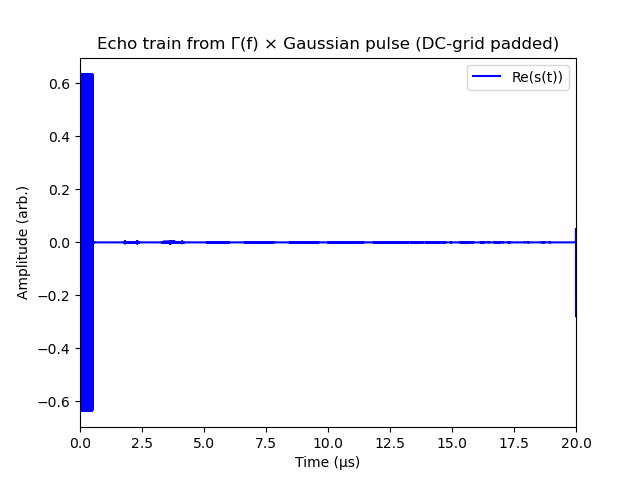

In [252]:
##### 

# IFFT to time
t2, s_t2 = ifft_one_sided_to_time(f_full2, S_full2, pad_factor=8, make_real=True,scale_physical=True,analytic_preserve_amplitude= True,window='taper',f_lo=min(freqs), f_hi=max(freqs), taper_frac=0.05)
# IFFT to time
#t, s_t = ifft_one_sided_to_time(f_full2, S_full2, scale_physical=True)
#t3, s_t3 = ifft_one_sided_to_time(f_full, S_full, pad_factor=8, make_real=True)
# ---------- plots ----------
#plt.figure()

#

fig, ax = plt.subplots()


ax.plot(t2*1e6, np.real(s_t2), label="Re(s(t))",       color="blue")
#ax.plot(t*1e6,  np.real(s_t),  label="Re(s(t)) Mason", color="orange")

#ax.plot(t3*1e6,  np.real(s_t3),  label="Re(s(t)) Mason", color="green")
ax.set_xlabel("Time (µs)")
ax.set_ylabel("Amplitude (arb.)")
ax.set_title("Echo train from Γ(f) × Gaussian pulse (DC-grid padded)")
ax.set_xlim(0, 20)
#ax.set_ylim(-32e-6, 32e-6)

ax.legend()
#fig.tight_layout()
#fig.savefig("echo_train.png", dpi=300, bbox_inches="tight")
plt.show()



NameError: name 't' is not defined

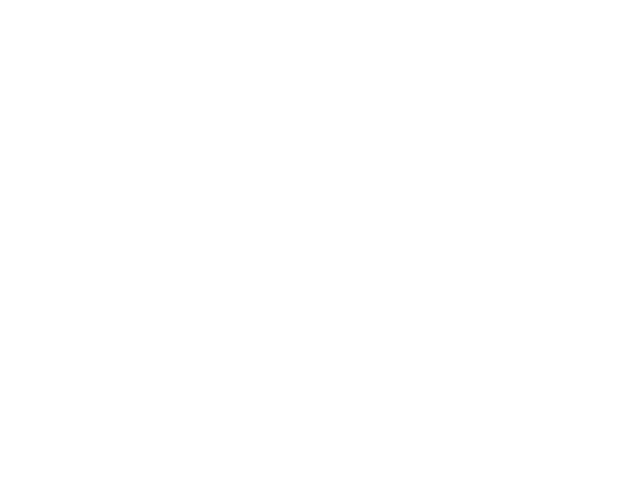

In [253]:
plt.figure()
plt.plot(t*1e6, np.abs(s_t2), label="|s(t)|")
plt.xlabel("Time (µs)")
plt.ylabel("Envelope (arb.)")
plt.title("Echo envelope")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

In [ ]:
# Cell — load the file
data = np.load("lvm_channels.npz")

# list what’s inside
sorted(data.files)[:10]


In [ ]:
t = data["echo0__t_s"]
amp = data["echo0__amp"]
plt.plot(t*1e6, amp)
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude (arb.)")
plt.title("echo0")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 1 — choose the time gate (e.g. 0 to 1 µs) from echo0


# # Gate in microseconds:
# t0_us, t1_us = 0.0, 1.0
# m = (t >= t0_us*1e-6) & (t <= t1_us*1e-6)

# t_gate = t[m]
# x_gate = amp[m]

# # Basic sanity checks
# dt = np.median(np.diff(t_gate))
# fs = 1.0/dt
# print(f"Gate samples: {len(x_gate)}  |  dt = {dt:.3e} s  |  fs = {fs/1e6:.2f} MHz")


In [ ]:
# Cell 1 — build a pulse record p(t) that lives on the *same indices* as echo0

import numpy as np
import matplotlib.pyplot as plt

def tukey_like(N: int, alpha: float = 0.3) -> np.ndarray:
    """Simple Tukey-style window without SciPy."""
    if N <= 1:
        return np.ones(N)
    alpha = float(alpha)
    if alpha <= 0:
        return np.ones(N)
    if alpha >= 1:
        return np.hanning(N)

    w = np.ones(N)
    edge = int(np.floor(alpha * (N - 1) / 2))
    if edge > 0:
        ramp = 0.5 * (1 - np.cos(np.pi * np.arange(edge) / edge))
        w[:edge] = ramp
        w[-edge:] = ramp[::-1]
    return w

def build_pulse_record_from_echo0(t_s, x, t0_us=0.0, t1_us=1.0, window="tukey", alpha=0.3, remove_mean=True):
    """
    Returns:
      p: pulse-only record, same length as x, aligned on exact sample indices
      idx0, idx1: gate indices in the original record
      dt: sample spacing
    """
    t = t_s - t_s[0]  # relative time
    dt = float(np.median(np.diff(t_s)))  # use full trace spacing

    t0 = t0_us * 1e-6
    t1 = t1_us * 1e-6
    m = (t >= t0) & (t <= t1)
    idx = np.flatnonzero(m)
    if idx.size == 0:
        raise ValueError("Gate produced zero samples. Check t0_us/t1_us.")

    idx0, idx1 = int(idx[0]), int(idx[-1])
    x_gate = x[idx0:idx1+1].copy()

    if remove_mean:
        x_gate = x_gate - np.mean(x_gate)

    if window == "tukey":
        w = tukey_like(len(x_gate), alpha=alpha)
    elif window == "hann":
        w = np.hanning(len(x_gate))
    elif window in (None, "none"):
        w = np.ones(len(x_gate))
    else:
        raise ValueError("window must be 'tukey', 'hann', or None/'none'")

    xw = x_gate * w

    p = np.zeros_like(x, dtype=float)
    p[idx0:idx1+1] = xw
    return p, (idx0, idx1), dt


#ch = channels["echo0"]
t_s = t
x = amp

p, (i0, i1), dt = build_pulse_record_from_echo0(t_s, x, t0_us=0.0, t1_us=1.0, window="tukey", alpha=0.3)

t_rel = (t_s - t_s[0])

# sanity overlay: p(t) should sit exactly on top of echo0 inside the gate (modulo mean/window)
plt.figure(figsize=(10,4))
plt.plot(t_rel*1e6, x, label="echo0 (measured)", linewidth=1)
plt.plot(t_rel*1e6, p, label="p(t) (gated+windowed, same grid)", linewidth=2)
plt.xlim(0, 5)
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude (arb.)")
plt.title("Pulse record on the original sample grid")
plt.legend()
plt.tight_layout()
plt.show()

print("Gate indices:", i0, i1, " | Gate duration (us):", (t_rel[i1]-t_rel[i0])*1e6)



In [ ]:
# Cell 2 — reconstruct echo-train s(t) from impedance-derived H(f), with matching length

def interp_complex(f_target, f_src, y_src, fill=0.0+0.0j):
    """Linear interpolate complex y_src(f_src) onto f_target."""
    y = np.empty_like(f_target, dtype=np.complex128)
    y[:] = fill
    band = (f_target >= f_src.min()) & (f_target <= f_src.max())
    y.real[band] = np.interp(f_target[band], f_src, np.real(y_src))
    y.imag[band] = np.interp(f_target[band], f_src, np.imag(y_src))
    return y

# --- You must provide these from your impedance calculation/measurement ---
# freqs_Z_Hz : 1D array (Hz)
# Z_complex  : 1D array (Ohms, complex), same length as freqs_Z_Hz

Z0 = 50.0  # ohms reference (change if needed)

N = len(x)
f = np.fft.rfftfreq(N, d=dt)

P = np.fft.rfft(p, n=N)
freqs_Z_Hz=freqs
Gamma_Z = Gamma2       # electrical reflection coefficient
H = interp_complex(f, freqs_Z_Hz, Gamma_Z, fill=0.0)  # put H on the FFT grid

S = H * P
s = np.fft.irfft(S, n=N)  # reconstructed echo-trace, same length as echo0


In [ ]:
# Cell 3 — auto-align (time shift) + scale, then overlay

# Cell — shift-only alignment (no extra scaling)

# Cell — shift-only alignment (no extra scaling)

def best_shift_only(y_ref, y_est):
    N = len(y_ref)
    a = y_ref - np.mean(y_ref)
    b = y_est - np.mean(y_est)
    corr = np.fft.irfft(np.fft.rfft(a) * np.conj(np.fft.rfft(b)), n=N)
    k = int(np.argmax(corr))
    if k > N//2:
        k -= N
    return k



def best_shift_scale(y_ref, y_est, extra_gain=1.0):
    N = len(y_ref)
    a = y_ref - np.mean(y_ref)
    b = y_est - np.mean(y_est)

    corr = np.fft.irfft(np.fft.rfft(a) * np.conj(np.fft.rfft(b)), n=N)
    k = int(np.argmax(corr))
    if k > N//2:
        k -= N

    y_shift = np.roll(y_est, k)
    scale = float(np.dot(y_ref, y_shift) / np.dot(y_shift, y_shift))
    return k, (extra_gain * scale)


# shift_samp, scale = best_shift_scale(x, s)
# s_aligned = scale * np.roll(s, shift_samp)

# print(f"Best shift = {shift_samp} samples = {shift_samp*dt*1e6:.3f} µs,  scale = {scale:.3g}")

# plt.figure(figsize=(10,4))
# plt.plot(t_rel*1e6, x, label="echo0 (measured)", linewidth=1)
# plt.plot(t_rel*1e6, s_aligned, label="reconstructed (aligned+scaled)", linewidth=1.5)
# plt.xlim(0, 20)
# plt.xlabel("Time (µs)")
# plt.ylabel("Amplitude (arb.)")
# plt.title("Echo-train overlay")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
pulse_gain=500
k, scale = best_shift_scale(x, s, extra_gain=pulse_gain)
s_aligned = scale * np.roll(s, k)


In [ ]:

# ---------- build reflection spectrum ----------
# Gamma = reflection_coeff(Ze, Z0=50.0)
# Gamma *= window_1d("Hann", len(freqs))
# # ---------- build reflection spectrum ----------
# Gamma2 = reflection_coeff(ZimpE, Z0=50.0)
# Gamma2 *= window_1d("Hann", len(freqs))

# P = gaussian_spectrum_from_time_fwhm(freqs, f0_hz=99.50e6, t_fwhm_s=0.25e-6, t0_s=0.50e-6)
# # ---------- build echo spectrum ----------
# S = Gamma * P*20
# S2 = Gamma2 * P*20
# t2, s_t2 = ifft_one_sided_to_time(f_full2, S_full2, pad_factor=8, make_real=False)


# # IFFT to time
# t, s_t = ifft_one_sided_to_time(f_full, S_full, pad_factor=8, make_real=False)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(t*1e6, np.real(s_t)*pulse_gain, label="Mason", color="blue")
# ax.plot(t_rel*1e6, x, label="measured echo0", color="orange")
# ax.plot(t2*1e6, np.real(s_t2)*pulse_gain, label="Re(s(t))", color="red")

# ax.set_xlim(1, 20)
# ax.set_ylim(-0.15,0.15)
# ax.set_xlabel("Time (µs)")
# ax.set_ylabel("Amplitude (arb.)")
# ax.legend()
# fig.tight_layout()
# plt.show()



In [ ]:
plt.close('all')